# Risk Evaluation for retail banks

## Introduction
### Plan for Investigation, Analysis, and POC Building

1. Assumptions
* The dataset is sufficient to predict payment difficulties despite class imbalance.
* Feature engineering and model optimization will enhance prediction performance.
* Ensemble models (like CatBoost, XGBoost, LightGBM) will provide better results than individual models.
  
2. Overall Objectives
* Understand the Problem: Clarify the goal of predicting clients' payment difficulties.
* Prepare the Data: Clean, balance, and refine the dataset for modeling.
* Build Predictive Models: Train and tune models to maximize relevant metrics (recall, AUCPR).
* Evaluate and Interpret: Use tools like SHAP to evaluate the tuned models and guide further feature selection.
* Deploy a Robust Model: Select the final model with high performance for real-world use.

3. Objectives for Each Step
* Data Exploration and Preprocessing:
    * Clean the data (handle missing values, searching for missing data patterns, imbalance, and outliers).
    * Explore and select relevant features.
* Feature Engineering and Selection:
    * Create new features and refine the feature set to improve model performance.
    * Perform statistical tests that justify feature selection
    * Inspect a subset of selected features visually
    * Perform hypothesis testing and compose Confidence intervals to confirm the previous selection
* Baseline Model Training:
    * Train initial models to understand the baseline performance (focus on recall and AUCPR balance).
* Hyperparameter Tuning:
    * Optimize models for better performance by adjusting key parameters.
* SHAP Analysis and Feature Refinement:
    * Use SHAP to understand feature importance and refine the feature set.
* Final Evaluation and Model Selection:
    * Compare models, select the best one based on performance, and finalize it for deployment.

### Content:
1. Notebook setup
2. Data Cleaning
    1. Duplicate entries
    2. Missing values
       * Missing values pattern search
       * Missing value correlation
    4. Outliers
3. Feature engineering and selection
    1. Sample sizes and train-validation splitting
    2. Feature engineering
    3. Feature selection:
        1. Numeric feature selection
        2. Categorical feature selection 
4. The subset of selected features general overview
    1. Feature distributions
       * Numeric features
       * Categorical features
    3. Feature relationship with TARGET
       * Numeric features
       * Categorical features
    5. Feature correlations
    6. Variance Inflation Factor (VIF)
5. Selected Features Hypothesis testing
    1. Categorical features
        1. Chi Square test for difference in proportion
        2. 95% confidence interval of difference in proportion
    2. Luxury services and Age means value comparisons
        1. Levene's test of equal variance
        2. One-sided t-tests
        3. 95% confidence interval of mean difference
        4. Cohen's d test  
6. EDA conclusions 
7. Preprocessing 
    1. Preprocessing pipeline creation
    2. Preprocessing training, validation and test data
8. Payment difficulties prediction
    1. Selecting models
    2. Hyperparameter tuning
    3. SHAP values feature selection
    4. Final model creation and export
9. Project conclusions
10. Suggestions for improvement

## 1. Notebook setup

This secion includes:
* importing the needed libraries
* creating color_palette and label_text dictionaries which will be used for visualization purposes
* reading the train.csv and saving it to a Dataframe

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import pyspark
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials, SparkTrials
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform
from sklearn.model_selection import (
    cross_validate,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    average_precision_score,
    make_scorer,
    precision_recall_curve,
)

from statsmodels.stats.outliers_influence import (
    variance_inflation_factor as VIF,
)
import phik
from sklearn.exceptions import NotFittedError
from statsmodels.tools.tools import add_constant
import missingno as msno

from data_cleaning import tukey_fences_method, handle_duplicates_method
from dict_from_file import create_dictionary
from feature_selection import (
    impute_missing_values,
    compute_snr,
    compute_spearman_correlation,
    compute_mutual_information,
    compute_model_importance,
    rank_features,
    compute_odds_ratio,
    compute_mutual_information_categorical,
    compute_chi_square,
    compute_woe,
    rank_categorical_features,
    calculate_rank_with_thresholds,
)

from preprocessing import (
    FeatureExtractionTransformer,
    DropUnselectedColumns,
    EncodeOrganizationType,
    ReorderColumns,
    DecodeCatOrdEncoding,
)
import shap
from hist_plot import (
    plot_numeric,
    plot_categorical,
    plot_cat_vs_target,
    plot_selection_heatmap,
)

from CI_95 import CI_95_proportion, CI_95_cat_diff, CI_95_mean_diff

from hyperparameter_tuning import (
    get_hyperparameter_space,
    objective,
    get_hypertuned_models,
    get_HT_model_scores,
    get_SHAP_model_scores,
)
import zipfile


import time
import warnings
from google.cloud import storage
import os
import pickle
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import (
    convert_variables_to_constants_v2,
)

warnings.filterwarnings("ignore", message=".*interval columns not set.*")
warnings.filterwarnings(
    "ignore", message="Not enough unique value for variable"
)
warnings.filterwarnings("ignore", message="interval columns not set, guessing")
warnings.filterwarnings("ignore", message=".*LightGBM binary classifier.*")

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

### Creating resources for visualizations

In [3]:
RANDOM_STATE = 42
color_palette = create_dictionary("colors.txt")

### Reading data

In [4]:
application_train = pd.read_csv("data/application_train.csv", index_col=0)
application_test = pd.read_csv("data/application_test.csv", index_col=0)

In [5]:
application_prev = pd.read_csv("data/previous_application.csv", index_col=0)
bureau = pd.read_csv("data/bureau.csv", index_col=1)
bureau_balance = pd.read_csv("data/bureau_balance.csv", index_col=0)
bureau_balance = bureau_balance.merge(
    bureau[["SK_ID_CURR"]], left_index=True, right_index=True, how="left"
)
POS_CASH_balance = pd.read_csv("data/POS_CASH_balance.csv", index_col=0)
credit_card_balance = pd.read_csv("data/credit_card_balance.csv", index_col=0)
installments_payments = pd.read_csv(
    "data/installments_payments.csv", index_col=0
)

### 2.A Missing values
Looking at the main application_train dataset we see that over a half - 67 out of 121 columns have missing values. </br>
At most column has 69.87 %	of missing records and seeing that this perventages repeatps for COMMONAREA_MEDI, COMMONAREA_AVG, and
COMMONAREA_MODE	hints that the columns display similar imformation like median, average and mode of  common area. </br>
In tottal if we were to remove rows that have at least 1 missing value we wil loose 97.2 % of rows which is too big of a loss. On the otehr hand those rows include only 7.9 % of the possitive cases.


In [6]:
if application_train.isnull().any().any():
    missing_dict = {}
for col in application_train.columns:
    if application_train[col].isnull().any():
        missing_dict[col] = (
            "Yes",
            round(
                application_train[col].isnull().sum()
                * 100
                / application_train.shape[0],
                2,
            ),
            f"{round(application_train[application_train.TARGET == 1][col].isnull().sum()*100/application_train.shape[0], 2)} %",
        )
    else:
        missing_dict[col] = ("No", "-", "-")

missing_dict["Totals"] = (
    f"{application_train.isnull().any().sum()}/{application_train.shape[1]} columns have missing",
    f"{round(application_train.isnull().any(axis=1).sum()*100/application_train.shape[0], 2)} % of rows",
    f"{round(application_train[application_train.TARGET == 1].isnull().any(axis=1).sum()*100/application_train.shape[0], 2)} % of rows",
)
df_missing_data = pd.DataFrame(
    data=missing_dict.values(),
    index=missing_dict.keys(),
    columns=["Missing", "Percentage", "Percantage defaulted"],
)
display_results = df_missing_data[
    df_missing_data["Missing"] == "Yes"
].sort_values(by=["Percentage"], ascending=False)
display_results.loc["Totals"] = df_missing_data.loc["Totals"]
pd.set_option("display.max_rows", None)
display_results["Percentage"] = (
    display_results["Percentage"].astype(str) + " %"
)
display(display_results)
pd.reset_option("display.max_rows")
missing_cols = df_missing_data[df_missing_data["Missing"] == "Yes"].index
under_half_missing = list(
    df_missing_data[
        (df_missing_data["Missing"] == "Yes")
        & (
            df_missing_data[df_missing_data["Missing"] == "Yes"]["Percentage"]
            < 50
        )
    ].index
)
for col in list(df_missing_data[df_missing_data["Missing"] == "No"].index):
    under_half_missing.append(col)

,Missing,Percentage,Percantage defaulted
COMMONAREA_MEDI,Yes,69.87 %,5.99 %
COMMONAREA_AVG,Yes,69.87 %,5.99 %
COMMONAREA_MODE,Yes,69.87 %,5.99 %
NONLIVINGAPARTMENTS_MEDI,Yes,69.43 %,5.96 %
NONLIVINGAPARTMENTS_MODE,Yes,69.43 %,5.96 %
NONLIVINGAPARTMENTS_AVG,Yes,69.43 %,5.96 %
FONDKAPREMONT_MODE,Yes,68.39 %,5.89 %
LIVINGAPARTMENTS_MODE,Yes,68.35 %,5.89 %
LIVINGAPARTMENTS_MEDI,Yes,68.35 %,5.89 %
LIVINGAPARTMENTS_AVG,Yes,68.35 %,5.89 %


C:\Users\godak\AppData\Local\Temp\ipykernel_23136\153530391.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_missing_data[


#### 2.A.a Missing values: pattern search
If we sample random 300 records of the columns that have missing data we see a again that some features display a clear pattern in the missing data and they do seem to be quite consistent. </br>
This hints that the dataset might have more than several columns that display similar information like we saw in common are case.

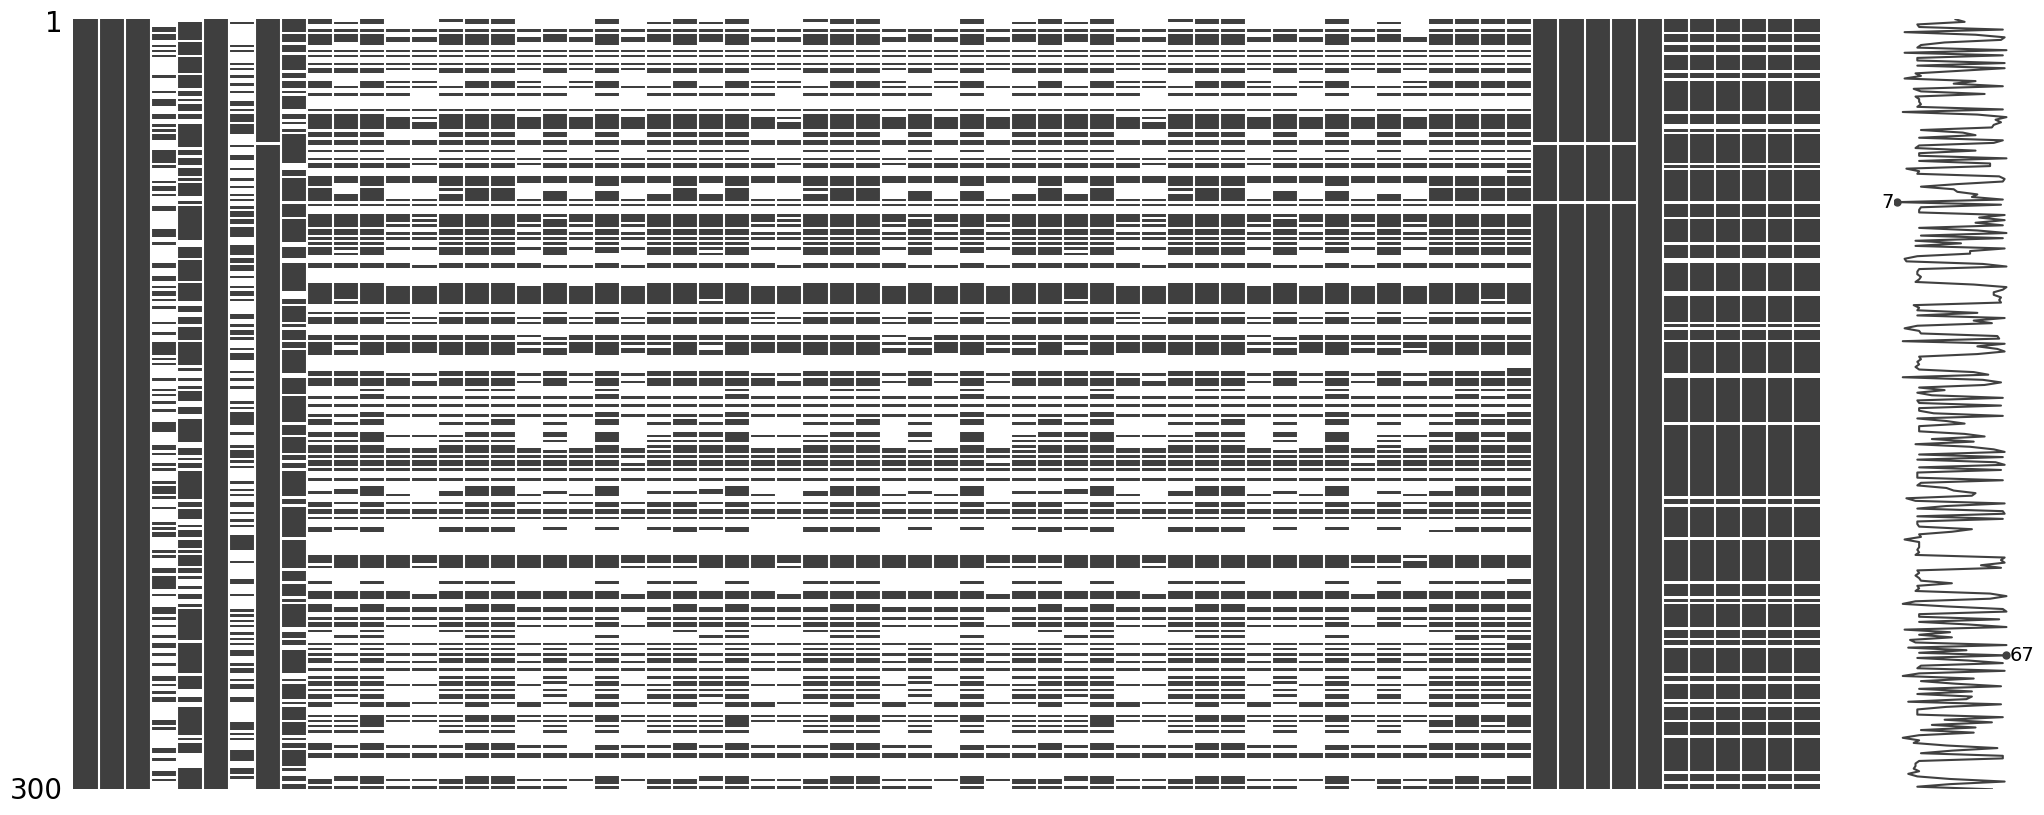

In [7]:
msno.matrix(application_train[missing_cols].sample(300));

#### 2.A.b Missing values: correlations

Since it would be interesting to look at columns that form a pattern like always missing togeter we calculate correlation matix which marks such relationship with 1. </br>
Since it is a bit difficult to see the pairs in the heetmap they are being printed bellow.</br>
We see that the majority of such relationships are between features having a different gradularity like AMT_REQ_CREDIT_BUREAU_DAY, _WEEK, _MON, _QTR,  _YEAR or having different agregations _MEDI, _AVG or, _MODE. 

</br> One exception is for pairs of OBS_60_CNT_SOCIAL_CICLE (people in client's social surroundings with observable 60 DPD (days past due) default) andL DEF_60_CNT_SOCIAL_CICLE (people in client's social surroundings who defaulted on 60 (days past due) DPD) which still shares similar information.
</br></br>
Keeping these repateative records makes the data needlessly sparse thus we will remove one of the pair items if spotted.

<Figure size 1500x1000 with 0 Axes>

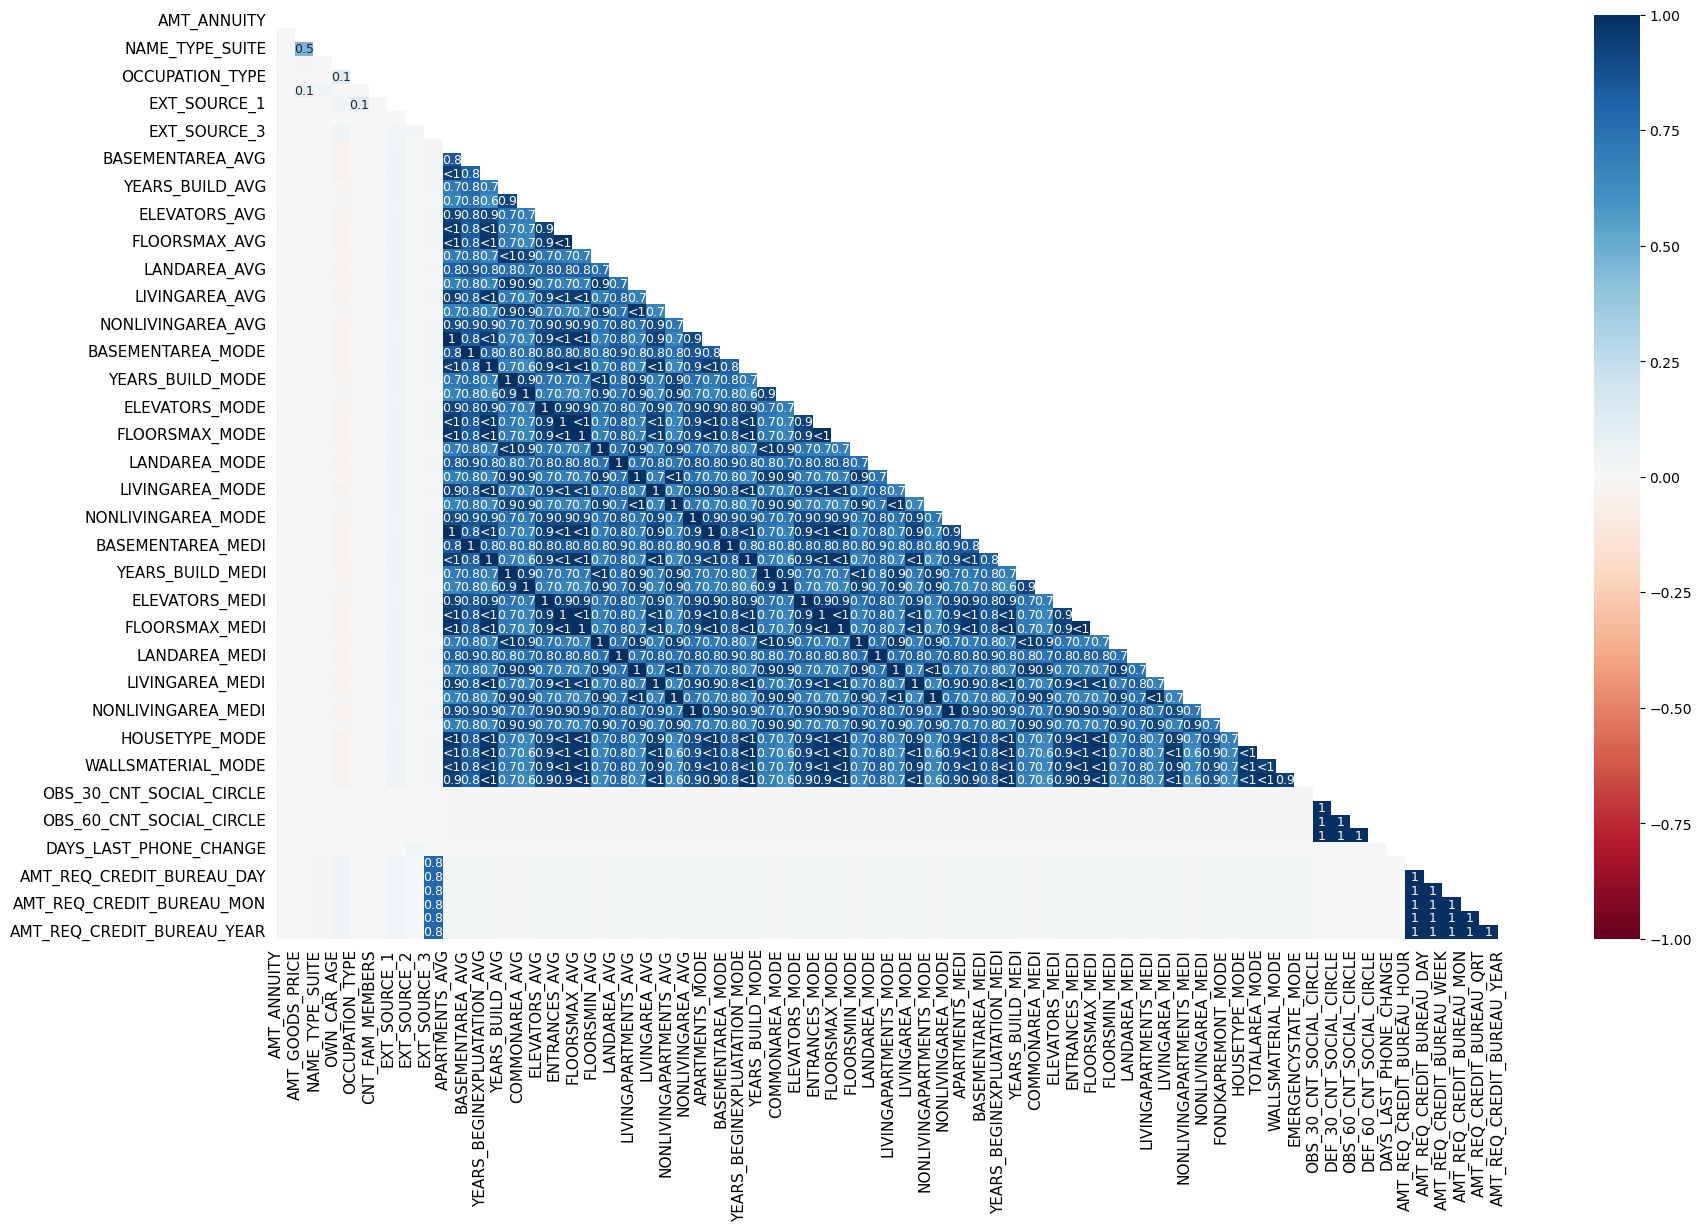

In [8]:
plt.figure(figsize=(15, 10))
msno.heatmap(application_train[missing_cols], fontsize=11)  # , cmap="icefire")
plt.xticks(rotation=90, ha="right")
plt.show();

In [9]:
missing_corr = application_train[missing_cols].isnull().corr()
identically_missing = set(
    [
        (col1, col2)
        for i, col1 in enumerate(missing_corr.columns)
        for j, col2 in enumerate(missing_corr.columns)
        if i < j and missing_corr.loc[col1, col2] == 1
    ]
)

print(
    f"Feature pairs with perfect correlation (total {len(identically_missing)} pairs):"
)
identically_missing_list = set()
for pair in sorted(identically_missing):
    print(pair)
    identically_missing_list.add(pair[0])
    identically_missing_list.add(pair[1])

Feature pairs with perfect correlation (total 63 pairs):
('AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON')
('AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_QRT')
('AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK')
('AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_YEAR')
('AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY')
('AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON')
('AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_QRT')
('AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK')
('AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_YEAR')
('AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT')
('AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR')
('AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR')
('AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON')
('AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT')
('AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR')
('APARTMENTS_AVG', 'APARTMENTS_MEDI')
('APA

#### Missing client records

Since there are additional resources it is worth checking how many clients that applied have their records in those resources. </br>
As you may see credit_card_balance table has the biggest number and percentage of missing cient records thus it would be wise to discard it. Similarly bureau_balance has over 70% missing data for the training set which prompts that while training a model the information that might be usefull in the records will less likely to be captured thus even though percentage is not that high in test set it will be discarded.</br></br>
Other tables have up to 6% of missing client records in the training dataset  and up to 2% in the test dataset wich could easily be filled with imputation.

In [10]:
datasets_no_bureau = {
    "application_prev": application_prev,
    "POS_CASH_balance": POS_CASH_balance,
    "credit_card_balance": credit_card_balance,
    "installments_payments": installments_payments,
    "bureau": bureau,
    "bureau_balance": bureau_balance,
}
main_clients = set(application_train.index)
missing_clients_summary = {}
main_dfs = {
    "application_train": application_train,
    "application_test": application_test,
}
for df_name, df_main in main_dfs.items():
    main_clients = set(df_main.index)
    for name, data in datasets_no_bureau.items():
        other_clients = set(data["SK_ID_CURR"].unique())
        missing_clients = main_clients - other_clients
        missing_count = len(missing_clients)
        missing_percentage = (missing_count / len(main_clients)) * 100
        missing_clients_summary[df_name, name] = {
            "No. of Clients": missing_count,
            "Missing %": f"{round(missing_percentage, 2)} %",
        }

summary_df = pd.DataFrame.from_dict(missing_clients_summary, orient="index")
summary_df.index = pd.MultiIndex.from_tuples(
    summary_df.index, names=["Dataset", "Metric"]
)
summary_df = summary_df.reset_index()
final_df = summary_df.pivot(index="Dataset", columns="Metric")
final_df.columns = pd.MultiIndex.from_tuples(
    [(col[1], col[0]) for col in final_df.columns], names=["Metric", "Details"]
)
final_df = final_df.reorder_levels(
    order=["Metric", "Details"], axis=1
).sort_index(axis=1, level=0, ascending=False)
final_df

Metric            installments_payments           credit_card_balance  \
Details                  No. of Clients Missing %      No. of Clients   
Dataset                                                                 
application_test                    800    1.64 %               32091   
application_train                 15868    5.16 %              220606   

Metric                      bureau_balance                   bureau            \
Details           Missing % No. of Clients Missing % No. of Clients Missing %   
Dataset                                                                         
application_test    65.84 %           6433    13.2 %           6424   13.18 %   
application_train   71.74 %         215280   70.01 %          44020   14.31 %   

Metric            application_prev           POS_CASH_balance            
Details             No. of Clients Missing %   No. of Clients Missing %  
Dataset                                                                  
application_test               944    1.94 %              936    1.92 %  
application_train            16454    5.35 %            18067    5.88 %

#### Filling missing values from external sources

As you can see bellow external filles cannot be used to directly filling the missing values since there are no columns in common.
The application_prev does have some columns in common however they refrer to the previous application not current. 

In [11]:
datasets_common_columns = {
    "application_prev": application_prev,
    "POS_CASH_balance": POS_CASH_balance,
    "credit_card_balance": credit_card_balance,
    "installments_payments": installments_payments,
    "bureau": bureau,
}
for name, df in datasets_common_columns.items():
    common = set(application_train.columns).intersection(df.columns)
    print(f"{name} has in common: {common} columns {df.index.name}")

application_prev has in common: {'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'AMT_CREDIT', 'NAME_CONTRACT_TYPE', 'HOUR_APPR_PROCESS_START'} columns SK_ID_PREV
POS_CASH_balance has in common: set() columns SK_ID_PREV
credit_card_balance has in common: set() columns SK_ID_PREV
installments_payments has in common: set() columns SK_ID_PREV
bureau has in common: {'AMT_ANNUITY'} columns SK_ID_BUREAU


### 2.B Duplicate entries

Since we have used SK_ID_CURR or SK_ID_PREV unique IDs as index of the dataframes we can be sure that there are no duplicated clients.

### 2.C Outliers

Since there are 120 features in the application_train dataset only the features that match these criteria are checked for outliers:
* The feature must have over 50 % of data that is not missing
* The feature should not have highly skewed distribution - for this dataset that means over 65% of the data be a of same value since Tukey's fences are not well-suited for this and assumes a reasonably symmetric and spread-out distribution. Typically if it is 0 and Tukey Fences method then identifies points of 0 and close to 0 as outliers.
</br></br>

We see that here the outliers of each feature are up to 3% of all data. </br>
If we were to remove the outliers from the features which satisfied the conditions above we would only need to remove 20014 records which is 6.51 % of all data. The decision is to keep them instead.

In [12]:
outlier_data = {}
out_to_drop = set()
float_cols = application_train.dtypes[
    application_train.dtypes == "float"
].index
outlier_check_columns = set(float_cols).intersection(set(under_half_missing))

for feature in outlier_check_columns:
    if application_train[feature].value_counts().iloc[0] <= 200000:
        outliers, proc = tukey_fences_method(
            application_train[under_half_missing], feature
        )
        for out_val in outliers:
            out_to_drop.add(application_train.iloc[out_val].name)
        len_out = len(outliers)
        outlier_data[feature] = (
            len_out,
            proc,
        )

out_df = pd.DataFrame(
    data=outlier_data.values(),
    index=outlier_data.keys(),
    columns=[
        "Number of outliers",
        "Percentage of data loss",
    ],
)
out_df.loc["Totals"] = {
    "Number of outliers": len(out_to_drop),
    "Percentage of data loss": f"{round(len(out_to_drop) * 100 / application_train.shape[0], 2)} %",
}
out_df.sort_values(by="Number of outliers", ascending=False)

,Number of outliers,Percentage of data loss
Totals,20014,6.51 %
OBS_30_CNT_SOCIAL_CIRCLE,9128,2.97 %
OBS_60_CNT_SOCIAL_CIRCLE,8871,2.88 %
TOTALAREA_MODE,4307,1.4 %
AMT_INCOME_TOTAL,3094,1.01 %
YEARS_BEGINEXPLUATATION_MODE,1455,0.47 %
YEARS_BEGINEXPLUATATION_AVG,1420,0.46 %
YEARS_BEGINEXPLUATATION_MEDI,1376,0.45 %
AMT_GOODS_PRICE,1093,0.36 %
AMT_ANNUITY,1024,0.33 %


## 3. Preprocessing

### 3.A Sample sizes and train-validation splitting
In total training contains 307511 records only 24825 of which are of people who had loans that defaulted which is only 8.07% (compared to the remaining 282686 that did not). </br>
This hints that there should be Sample Ratio Mismatch (SRM) thus Chi Square test of independence will be conducted.

#### Chi Square test

According to Chi-Square test the p-value is significantly lower than the common significance level of 0.05. </br>
This indicates that there is significant difference between the observed and expected sample sizes.</br>
In other words, **the SRM is detected** and the difference of people who had loans that defaulted and those who did not, has NOT occur by chance thus the dataset is imbalanced. This will be taken into consideration when training the models.

In [13]:
observed = [
    application_train.loc[
        application_train[application_train["TARGET"] == 0].index
    ].shape[0],
    application_train.loc[
        application_train[application_train["TARGET"] == 1].index
    ].shape[0],
]
total_records = sum(observed)
expected = [total_records / 2, total_records / 2]

chi = stats.chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=216227.3717720667, pvalue=0.0)


#### Data splitting

In [14]:
train_data, val_data, train_target, val_target = train_test_split(
    application_train,
    application_train["TARGET"],
    test_size=0.2,
    stratify=application_train["TARGET"],
    random_state=RANDOM_STATE,
)
train_data.drop(columns="TARGET", inplace=True)
val_data.drop(columns="TARGET", inplace=True)

### 3.B Feature engineering

Since we saw that credit_card_balance has over 50% of missing values in both datasets and bureau_balance - over 70% in training set we will be engineering the following features from these datasets:
* **installments_payments**:
    1.  AVG_INSTALMENT_DEBT - the average difference between the payed ammount and instalment (AMT_PAYMENT- AMT_INSTALMENT)
    2.  AVG_INSTALMENT_DELAY - the average ammount of days the installemnt was late to be payed (DAYS_ENTRY_PAYMENT- DAYS_INSTALMENT)
* **bureau**:
    1. AMT_CREDIT_SUM_STD - the standard deviation of the ammount of credit
    2. AMT_CREDIT_SUM_DEBT_AVG - the average ammount of debt
    3. AMT_CREDIT_SUM_OVERDUE_FLAG - flags if there is any ammount overdue
    4. DEBT_TO_CREDIT_AVG - average debt to credit ratio calculated by AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM
    5. CREDIT_ACTIVE_COUNT -  the count of active credits 
    6. CREDIT_DAY_OVERDUE_AVG -  the average number of days past due on Credit Bureau credit at the time of application for related loan
    7. CNT_CREDIT_PROLONG_AVG -  the average number of times credits were prolonged
* **application_prev**:
    1. W_CREDIT_APPROVAL_DIFF - the weighted average difference of the ammount of credit applied and granted after evaluation. The weight helps include relevance and is calculated based on DAYS_DECISION column (the ammount of days has passed between current and previous application decision date)
    2. W_ANUITY_GROWTH - the increase/decrease in anuity between current and latest previous application which is weighted based on DAYS_DECISION
    3. W_CREDIT_GROWTH - the increase/decrease in credit amount between current and latest previous application which is weighted based on DAYS_DECISION
    4. CASH_LOAN_COUNT - count of cash type previous applications
    5. REVOLVING_LOAN_COUNT - count of revolving type previous applications
* **POS_CASH_balance**:
    1. SK_DPD_AVG - the average of days past due of client previous applications
    2. SK_DPD_STD - the standard deviation of days past due of client previous applications

In [15]:
engineer_features = FeatureExtractionTransformer(
    installments_payments=installments_payments,
    bureau=bureau,
    application_prev=application_prev,
    POS_CASH_balance=POS_CASH_balance,
)
train_data_for_full_pipeline = train_data.copy()
train_data = engineer_features.transform(train_data)
engineered_cols = set(train_data.columns[-16:])
train_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CREDIT_ACTIVE_COUNT,CREDIT_DAY_OVERDUE_AVG,CNT_CREDIT_PROLONG_AVG,W_CREDIT_APPROVAL_DIFF,W_ANNUITY_GROWTH,W_CREDIT_GROWTH,CASH_LOAN_COUNT,REVOLVING_LOAN_COUNT,SK_DPD_AVG,SK_DPD_STD
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
310536,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,Unaccompanied,...,2.0,0.0,0.0,-145.861032,-14.390263,-343.863988,2.0,1.0,0.0,0.0
365516,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,Unaccompanied,...,NaN,NaN,NaN,-18.691735,13.807788,383.653846,2.0,NaN,0.0,0.0
242055,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,553500.0,"Spouse, partner",...,2.0,0.0,0.0,1.372213,5.300953,271.993830,NaN,NaN,0.0,0.0
454894,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,391500.0,Unaccompanied,...,NaN,0.0,0.0,-32.499365,101.298273,1661.809091,6.0,NaN,0.0,0.0
448321,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,225000.0,Unaccompanied,...,NaN,NaN,NaN,0.100216,NaN,1207.109005,1.0,NaN,0.0,0.0


### 3.C Feature Selection

We will be performing feature selection for the 2 groups independently:
* Numeric features will be chosen if the majority of the following methods deems the feature to be important:
    1.  Signal-to-Noise Ratio (SNR)
    2.  Spearman Correlation
    3.  Mutual Information
    4.  XGBoost feature importance
* Categorical features:
    1. Odds ratio
    2. Mutual information
    3. Chi-Square Test
    4. Weight of Evidence 

#### 3.C.a Numeric feature selection

In [16]:
numeric_columns = []
days_int_columns = []
for col in train_data.columns:
    if (col[:4] == "DAYS") and (train_data[col].dtype == np.int64):
        numeric_columns.append(col)
        days_int_columns.append(col)
numeric_columns.extend(train_data.select_dtypes(include=["float64"]).columns)

##### 1.  Signal-to-Noise Ratio (SNR)

We see that the range of the score for application_train dataset features is from  0.0026 to 0.5629. </br>
One can consider the following ranges:
* High Information Features: 0.3–0.5.
* Moderate Information Features: 0.1–0.3 may add value but should be considered secondary.
* Low Information Features: bellow 0.1

Having in mind that the SNR ranges are from 0 to 1 the received interval is decent enough. 

In [17]:
snr_scores = compute_snr(
    train_data[numeric_columns].join(train_target),
    "TARGET",
)
snr_scores

Data contains NaN values. Proceeding with imputation.


EXT_SOURCE_3                0.281456
EXT_SOURCE_2                0.279868
EXT_SOURCE_1                0.181201
DAYS_BIRTH                  0.148804
DAYS_LAST_PHONE_CHANGE      0.102795
                              ...   
NONLIVINGAPARTMENTS_MODE    0.001227
DEBT_TO_CREDIT_AVG          0.000645
NONLIVINGAPARTMENTS_AVG     0.000393
W_CREDIT_GROWTH             0.000179
NONLIVINGAPARTMENTS_MEDI    0.000026
Name: SNR, Length: 84, dtype: float64

##### 2.  Spearman Correlation

We see that the range of the score for application_train dataset features is from  -0.1471 to 0.0537. </br>
Having in mind that the Spearman correlation ranges are from -1 to 1 the received interval is quite small. </br>
Typically |0.1| is chosen as a threshold however in this case only EXT_SOURCE_3 and EXT_SOURCE_2 would be chosen due to this we will not be relying on this metric when calculating rating.

In [18]:
spearman_corr_scores = compute_spearman_correlation(
    train_data[numeric_columns].join(train_target),
    "TARGET",
)
spearman_corr_scores

TARGET                    1.000000
DEBT_TO_CREDIT_AVG        0.095942
DAYS_BIRTH                0.079573
DAYS_LAST_PHONE_CHANGE    0.051856
DAYS_ID_PUBLISH           0.050700
                            ...   
W_CREDIT_APPROVAL_DIFF   -0.033993
AVG_INSTALMENT_DEBT      -0.059051
EXT_SOURCE_1             -0.086202
EXT_SOURCE_3             -0.144937
EXT_SOURCE_2             -0.146343
Length: 85, dtype: float64

##### 3.  Mutual Information

We see that the range of the score for application_train dataset features is from 0.0003 to 0.0408.
Mutual Information ranges vary depending on the domain however these are considered typical:
* Very low MI: 0 to 0.01 (indicates little to no relationship).
* **Low to moderate MI: 0.01 to 0.1 (weak but potentially useful relationships).**
* Moderate to high MI: 0.1 to 0.3 (meaningful relationships).
* High MI: 0.3 and above (strong relationships).

Typically threshold of 0.01 or 0.05  is chosen however in this case 0.01 seems more usefull.



In [19]:
mut_inf_scores = compute_mutual_information(
    train_data[numeric_columns],
    train_target,
)
mut_inf_scores

DEF_30_CNT_SOCIAL_CIRCLE    0.014657
DEF_60_CNT_SOCIAL_CIRCLE    0.014560
EXT_SOURCE_3                0.013818
OBS_30_CNT_SOCIAL_CIRCLE    0.012061
EXT_SOURCE_2                0.011798
                              ...   
YEARS_BUILD_MEDI            0.000390
COMMONAREA_AVG              0.000294
COMMONAREA_MEDI             0.000150
W_ANNUITY_GROWTH            0.000000
LIVINGAPARTMENTS_AVG        0.000000
Name: Mutual Information, Length: 84, dtype: float64

##### 4.  XGBoost feature importance

We see that the range of the score for train_data dataset features is from 0.0015 to  0.0602.</br>
Tith Feature Importance in theoretical range are  from 0 to 1 however in practice seeing from 0 to 0.2 is more common. </br>
Typicalls a threshold from 0.01 to 0.05 is chosen.

In [20]:
feature_importance_scores = compute_model_importance(
    train_data[numeric_columns],
    train_target,
)
feature_importance_scores

EXT_SOURCE_3                 0.050093
AMT_REQ_CREDIT_BUREAU_DAY    0.045332
EXT_SOURCE_2                 0.045262
FLOORSMAX_MEDI               0.041105
EXT_SOURCE_1                 0.019115
                               ...   
FLOORSMIN_AVG                0.006807
FLOORSMAX_AVG                0.006604
COMMONAREA_AVG               0.006592
OBS_60_CNT_SOCIAL_CIRCLE     0.006592
NONLIVINGAPARTMENTS_MEDI     0.000907
Name: Feature Importance, Length: 84, dtype: float32

In [21]:
weights = {
    "SNR": 0.35,
    "Spearman": 0.05,
    "Mutual Information": 0.3,
    "Feature Importance": 0.3,
}
thresholds = {
    "SNR": 0.1,
    "Spearman": 0.1,
    "Mutual Information": 0.01,
    "Feature Importance": 0.01,
}
rank_scores = calculate_rank_with_thresholds(
    snr_scores,
    spearman_corr_scores,
    mut_inf_scores,
    feature_importance_scores,
    thresholds,
    weights,
)
rank_scores.sort_values(by="Rank Score", ascending=False).head(10)

,SNR,Spearman,Mutual Information,Feature Importance,Above threshold Score,Rank Score
EXT_SOURCE_3,0.281456,-0.144937,0.013818,0.050093,0.110436,38.0
EXT_SOURCE_2,0.279868,-0.146343,0.011798,0.045262,0.107755,37.0
EXT_SOURCE_1,0.181201,-0.086202,0.006484,0.019115,0.066790,36.0
DAYS_BIRTH,0.148804,0.079573,0.003606,0.013777,0.061275,35.0
DAYS_LAST_PHONE_CHANGE,0.102795,0.051856,0.003252,0.009521,0.042403,34.0
DAYS_EMPLOYED,0.089750,0.024974,0.009339,0.013188,0.039419,33.0
CREDIT_ACTIVE_COUNT,0.085586,0.037698,0.006327,0.011487,0.037184,32.0
AMT_GOODS_PRICE,0.078879,-0.031871,0.005171,0.016528,0.032524,31.0
FLOORSMAX_MEDI,0.056170,-0.016566,0.004528,0.041105,0.032521,30.0
DEF_60_CNT_SOCIAL_CIRCLE,0.054225,0.029607,0.014560,0.016457,0.029764,29.0


Here we simply include the columns that were not selected for display purposes.

In [22]:
nonselected_scores = pd.DataFrame(
    {
        "SNR": snr_scores,
        "Spearman": spearman_corr_scores,
        "Mutual Information": mut_inf_scores,
        "Feature Importance": feature_importance_scores,
        "Rank Score": np.nan,
    }
)
rank_scores = rank_scores.combine_first(nonselected_scores).sort_index()

#### Selection visualization:

In the heatmap we see that clearly not all features of the main dataset nor engineered ones are useful. If we select any feature that passes at least 1 of the tests we will select 37 out of 85 columns which is 43.53 %. </br>
Since we are planning to be more strict here we will choose the columns with above average rating score which is 19 out of 85 columns forming 22.35 % of the numeric columns.

The 4 methods selected 38 / 85 columns. 
    It is 44.71 %
Above mena rank selected  19 / 85 columns. 
    It is 22.35 %


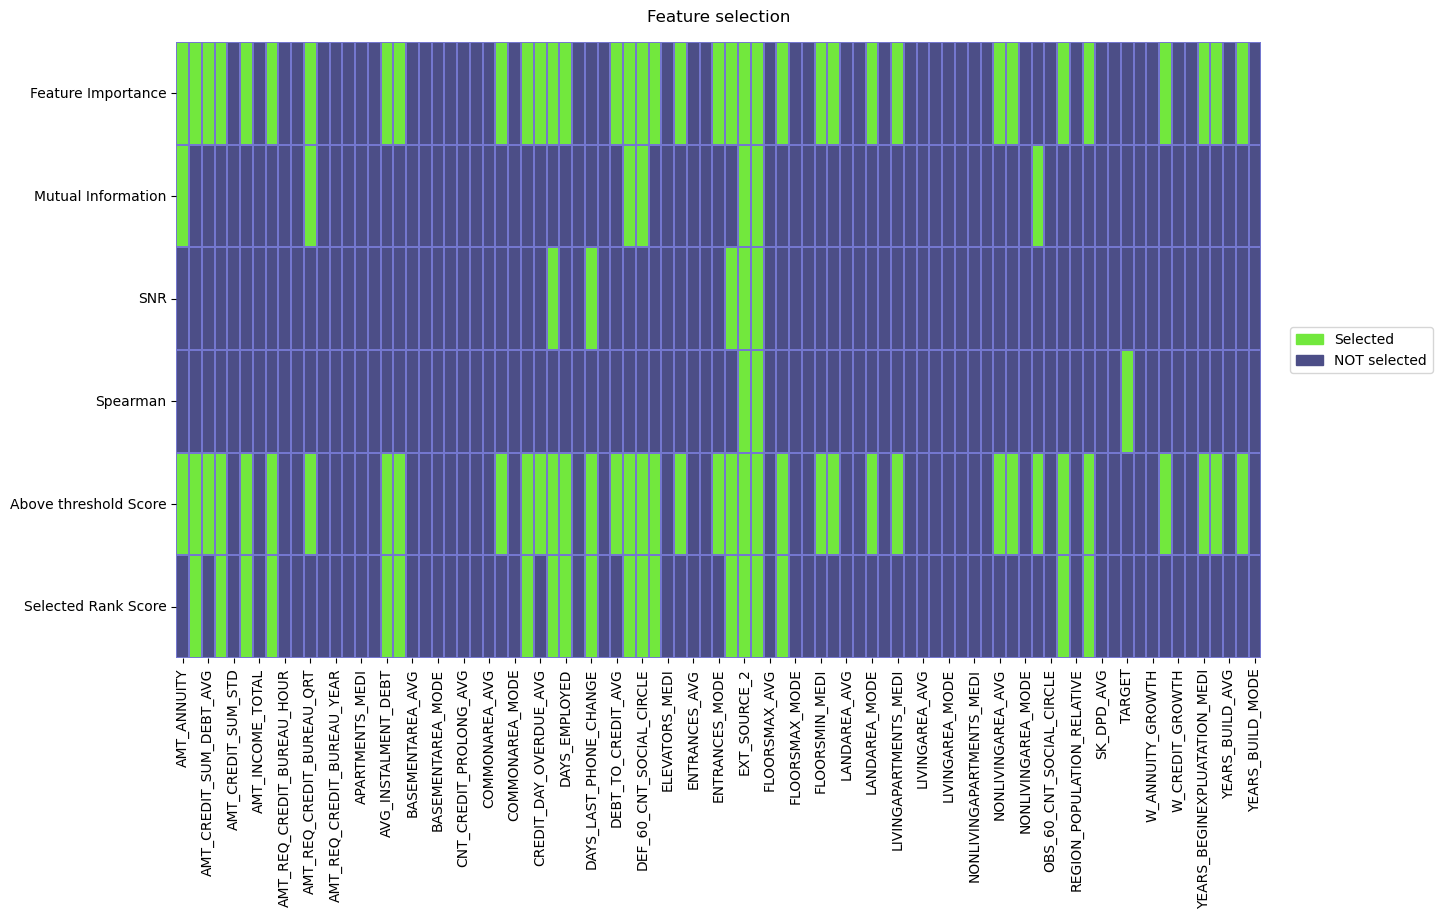

In [23]:
threshold_rank_scores = rank_scores.copy()
thresholds["Rank Score"] = rank_scores["Rank Score"].mean()

for col in thresholds:
    if col == "Spearman":
        threshold_rank_scores[col] = np.where(
            abs(threshold_rank_scores[col]) >= thresholds[col], 1, np.nan
        )
    else:
        threshold_rank_scores[col] = np.where(
            threshold_rank_scores[col] >= thresholds[col], 1, np.nan
        )

percentage_selected = round(
    threshold_rank_scores["Above threshold Score"].notna().value_counts()[True]
    * 100
    / len(threshold_rank_scores["Above threshold Score"]),
    2,
)
thresh_selected = (
    threshold_rank_scores["Above threshold Score"].notna().value_counts()[True]
)
total_cols = len(threshold_rank_scores["Above threshold Score"])
print(
    f"""The 4 methods selected {thresh_selected} / {total_cols} columns. 
    It is {percentage_selected} %"""
)
percentage_selected = round(
    threshold_rank_scores["Rank Score"].value_counts()[1]
    * 100
    / len(threshold_rank_scores["Rank Score"]),
    2,
)
rank_select_cols_count = threshold_rank_scores["Rank Score"].value_counts()[1]
print(
    f"""Above mena rank selected  {rank_select_cols_count} / {total_cols} columns. 
    It is {percentage_selected} %"""
)
prev_to_last = threshold_rank_scores.pop("Above threshold Score")
threshold_rank_scores["Above threshold Score"] = prev_to_last
last_col = threshold_rank_scores.pop("Rank Score")
threshold_rank_scores["Selected Rank Score"] = last_col

plot_selection_heatmap(threshold_rank_scores, 8)

#### 3.C.a Categorical feature selection


In [24]:
categoric_columns = list(
    set(train_data.select_dtypes(include=["int", "object"]).columns)
    - set(days_int_columns)
)
categoric_columns.sort()

##### Odds Ratio
Measures the strength of association between a categorical feature and the target variable.
Typical Range:
* OR=1: No association.
* OR>1: Positive association.
* OR<1: Negative association.

Threshold: Often 
* OR≥2 (moderate effect) or 
* OR≥3 (strong effect)

Odds Ration can produce very high values thus we will return the log(abs(OR value)) instead. </br>
In addition since log(1) = 0 this illustrates no association better and more similar to other tests.

In [25]:
odd_ratio_scores = compute_odds_ratio(
    train_data[categoric_columns].join(train_target),
    "TARGET",
)
odd_ratio_scores

CNT_CHILDREN                   48.690759
NAME_INCOME_TYPE               24.548277
FLAG_DOCUMENT_4                23.684509
FLAG_DOCUMENT_10               21.979681
CODE_GENDER                    21.536755
NAME_FAMILY_STATUS             21.523545
FLAG_MOBIL                     20.593373
FLAG_DOCUMENT_12               20.593373
NAME_EDUCATION_TYPE             2.027714
ORGANIZATION_TYPE               1.989585
FLAG_DOCUMENT_17                1.662068
OCCUPATION_TYPE                 1.515523
FLAG_DOCUMENT_2                 1.451778
FLAG_DOCUMENT_15                1.148418
FLAG_DOCUMENT_13                1.130240
HOUR_APPR_PROCESS_START         0.965576
REGION_RATING_CLIENT_W_CITY     0.928259
REGION_RATING_CLIENT            0.898860
FLAG_DOCUMENT_14                0.823078
WALLSMATERIAL_MODE              0.792495
FLAG_DOCUMENT_21                0.712999
NAME_HOUSING_TYPE               0.708085
REG_CITY_NOT_LIVE_CITY          0.522715
FLAG_EMP_PHONE                  0.513841
FLAG_DOCUMENT_16

##### 2. Mutual Information (MI)
Measures non-linear dependency between a feature and the target variable.
Typical Range:
* MI=0: No dependency.
* MI>0: Dependency exists.

Threshold: Usually 
* MI≥0.03−0.05.

In [26]:
mi_cat_scores = compute_mutual_information_categorical(
    train_data[categoric_columns],
    train_target,
)
mi_cat_scores.head()

OCCUPATION_TYPE                0.003117
ORGANIZATION_TYPE              0.002739
NAME_INCOME_TYPE               0.002030
REGION_RATING_CLIENT_W_CITY    0.001887
REGION_RATING_CLIENT           0.001756
Name: Mutual Information, dtype: float64

##### 3. Chi-square:

Typically we evaluate the chi-square test by looking if the p-value is smaller than a sygnificance level of 0.05. </br>
This unfortunatelly raises an issue since other tests are checking for the value to be geather than a threshold not lower. </br>
To keep the common trend we will invert p value (1 - p value) and look if resulting p values are higher than 0.95.

In [27]:
chi_square_scores = compute_chi_square(
    train_data[categoric_columns].join(train_target),
    "TARGET",
)
chi_square_scores

CNT_CHILDREN                   1.000000
FLAG_EMP_PHONE                 1.000000
FLAG_OWN_CAR                   1.000000
FLAG_PHONE                     1.000000
FLAG_WORK_PHONE                1.000000
HOUR_APPR_PROCESS_START        1.000000
LIVE_CITY_NOT_WORK_CITY        1.000000
NAME_CONTRACT_TYPE             1.000000
NAME_EDUCATION_TYPE            1.000000
NAME_FAMILY_STATUS             1.000000
NAME_HOUSING_TYPE              1.000000
NAME_INCOME_TYPE               1.000000
OCCUPATION_TYPE                1.000000
ORGANIZATION_TYPE              1.000000
REGION_RATING_CLIENT           1.000000
REGION_RATING_CLIENT_W_CITY    1.000000
REG_CITY_NOT_LIVE_CITY         1.000000
REG_CITY_NOT_WORK_CITY         1.000000
WALLSMATERIAL_MODE             1.000000
CODE_GENDER                    1.000000
TARGET                         1.000000
FLAG_DOCUMENT_13               1.000000
FLAG_DOCUMENT_6                1.000000
FLAG_DOCUMENT_3                1.000000
FLAG_DOCUMENT_16               1.000000


##### 4. Weight of Evidence (WoE)
Used in credit scoring to measure the strength of a feature in separating classes. </br>
Typical Range:</br>
Positive or negative values, with higher magnitudes indicating stronger separability.
</br></br>
Threshold: 
∣WoE∣≥0.1−0.2

In [28]:
woe_scores = compute_woe(
    train_data[categoric_columns].join(train_target),
    "TARGET",
)
woe_scores.head()

FLAG_DOCUMENT_17       0.830824
FLAG_DOCUMENT_15       0.573346
FLAG_DOCUMENT_13       0.562699
FLAG_DOCUMENT_14       0.409798
NAME_EDUCATION_TYPE    0.316025
Name: WOE, dtype: float64

In [29]:
cat_thresholds = {
    "Odds Ratio": 2,
    "Mutual Information": 0.03,
    "Chi-Square": 0.95,
    "WOE": 0.1,
}

rank_cat_scores = calculate_rank_with_thresholds(
    odd_ratio_scores,
    mi_cat_scores,
    chi_square_scores,
    woe_scores,
    cat_thresholds,
)
rank_cat_scores.sort_values(by="Rank Score", ascending=False)

,Odds Ratio,Mutual Information,Chi-Square,WOE,Above threshold Score,Rank Score
CNT_CHILDREN,48.690759,3.010997e-04,1.000000,-0.374811,14.632356,47.0
NAME_INCOME_TYPE,24.548277,2.030086e-03,1.000000,-0.177507,7.429591,46.0
FLAG_DOCUMENT_4,23.684509,7.527899e-06,0.682060,-0.000097,7.173541,45.0
FLAG_DOCUMENT_10,21.979681,1.368657e-06,0.000000,-0.000018,6.593901,44.0
NAME_FAMILY_STATUS,21.523545,8.726535e-04,1.000000,-0.007484,6.555829,43.0
CODE_GENDER,21.536755,1.444583e-03,1.000000,-0.048106,6.551839,42.0
FLAG_MOBIL,20.593373,3.421620e-07,0.000000,-0.000004,6.178011,40.5
FLAG_DOCUMENT_12,20.593373,3.421620e-07,0.000000,-0.000004,6.178011,40.5
NAME_EDUCATION_TYPE,2.027714,1.743123e-03,1.000000,0.316025,0.772042,39.0
FLAG_DOCUMENT_17,1.662068,1.001964e-05,0.892538,0.830824,0.754042,38.0


In [30]:
nonselected_cat_scores = pd.DataFrame(
    {
        "Odds Ratio": odd_ratio_scores,
        "Mutual Information": mi_cat_scores,
        "Chi-Square": chi_square_scores,
        "WOE": woe_scores,
        "Rank Score": np.nan,
    }
)
rank_cat_scores = rank_cat_scores.combine_first(nonselected_cat_scores)

#### Selection visualization:

When it comes to categorical data we see quite a different picture -  the heatmap shows that the majority of  features of the main dataset are useful. If we select any feature that passes at least 1 of the tests we will select 47 out of 53 columns which is 88.68 %. </br>
Since we are planning to be more strict here we will choose the columns with above average rating score which is 24 out of 53 columns forming 45.28 % of the categorical columns.

The 4 methods selected 47 / 53 columns. 
    It is 88.68 %
Above mena rank selected  24 / 53 columns. 
    It is 45.28 %


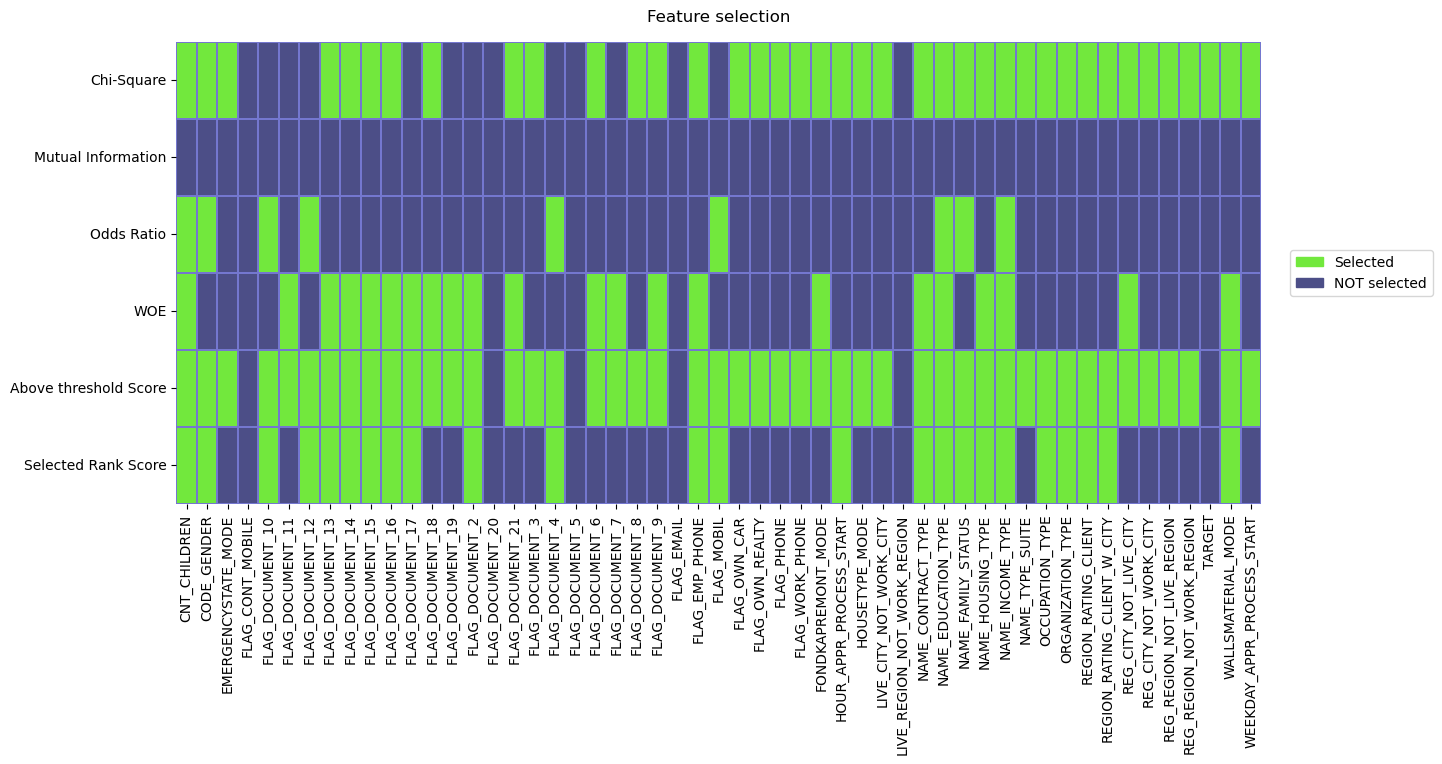

In [31]:
threshold_rank_cat_scores = rank_cat_scores.copy()
cat_thresholds["Rank Score"] = rank_cat_scores["Rank Score"].mean()
for col in cat_thresholds:
    if col == "WOE":
        threshold_rank_cat_scores[col] = np.where(
            abs(threshold_rank_cat_scores[col]) >= cat_thresholds[col],
            1,
            np.nan,
        )
    else:
        threshold_rank_cat_scores[col] = np.where(
            threshold_rank_cat_scores[col] >= cat_thresholds[col], 1, np.nan
        )

percentage_selected = round(
    threshold_rank_cat_scores["Above threshold Score"]
    .notna()
    .value_counts()[True]
    * 100
    / len(threshold_rank_cat_scores["Above threshold Score"]),
    2,
)
thresh_selected = (
    threshold_rank_cat_scores["Above threshold Score"]
    .notna()
    .value_counts()[True]
)
total_cols = len(threshold_rank_cat_scores["Above threshold Score"])
print(
    f"""The 4 methods selected {thresh_selected} / {total_cols} columns. 
    It is {percentage_selected} %"""
)
percentage_selected = round(
    threshold_rank_cat_scores["Rank Score"].value_counts()[1]
    * 100
    / len(threshold_rank_cat_scores["Rank Score"]),
    2,
)
rank_select_cols_count = threshold_rank_cat_scores[
    "Rank Score"
].value_counts()[1]
print(
    f"""Above mena rank selected  {rank_select_cols_count} / {total_cols} columns. 
    It is {percentage_selected} %"""
)

prev_to_last = threshold_rank_cat_scores.pop("Above threshold Score")
threshold_rank_cat_scores["Above threshold Score"] = prev_to_last
last_col = threshold_rank_cat_scores.pop("Rank Score")
threshold_rank_cat_scores["Selected Rank Score"] = last_col

plot_selection_heatmap(threshold_rank_cat_scores, 6)

#### Total ranking method selection

As mentioned previously we will try to avoid columns that are missing together from being in the final list thus below you will see the complete list of 43 features that are being selected by the ranking method from the  total of 136 columns. Luckily here we also see that feature engineering was not completely in vain - 5 out of 16 new features were selected. This list will get a bit modified later on.

In [32]:
rank_selected_columns = threshold_rank_scores[
    threshold_rank_scores["Selected Rank Score"].notna()
].index
selected_cat_columns = threshold_rank_cat_scores[
    threshold_rank_cat_scores["Selected Rank Score"].notna()
].index
rank_selected_columns = rank_selected_columns.append(selected_cat_columns)
engineered_and_selected = engineered_cols.intersection(
    set(rank_selected_columns)
)
print(
    f"""
    These {len(rank_selected_columns)}/{len(train_data.columns)} columns were selected:\n 
    {list(rank_selected_columns)}
    \n Out of them these {len(engineered_and_selected)} columns were engineered (total 16):
    {engineered_and_selected}
    """
)
rank_total_scores = pd.concat(
    [
        rank_cat_scores["Rank Score"],
        rank_scores["Rank Score"],
    ]
)

to_remove = []
for col1, col2 in identically_missing:
    if col1 in rank_selected_columns and col2 in rank_selected_columns:
        if rank_total_scores[col1] > rank_total_scores[col2]:
            to_remove.append(col2)
        else:
            to_remove.append(col1)

rank_selected_columns = [
    col for col in rank_selected_columns if col not in to_remove
]


    These 43/136 columns were selected:
 
    ['AMT_CREDIT', 'AMT_CREDIT_SUM_OVERDUE_FLAG', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AVG_INSTALMENT_DEBT', 'AVG_INSTALMENT_DELAY', 'CREDIT_ACTIVE_COUNT', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'ELEVATORS_AVG', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_MEDI', 'OWN_CAR_AGE', 'REVOLVING_LOAN_COUNT', 'CNT_CHILDREN', 'CODE_GENDER', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WALLSMATERIAL_MODE']
    
 Out of them these 5 columns were engineered (total 16):

In [33]:
with open("engineered_and_selected.pkl", "wb") as f:
    pickle.dump(engineered_and_selected, f)

## 4. The subset of selected features general overview

Below you will find the list of features which is a subset of the features selected by the tests above. </br>
Since visually analyzing 43 features would be a bit excessive we will fosus on these 13 and leave remaining for the hypothesis testing.

In [34]:
plot_numeric_cols = [
    "AMT_CREDIT",
    "AMT_GOODS_PRICE",
    "AVG_INSTALMENT_DEBT",
    "AVG_INSTALMENT_DELAY",
    "CREDIT_ACTIVE_COUNT",
    "REVOLVING_LOAN_COUNT",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
]
plot_categoric_cols = [
    "CODE_GENDER",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
]

### 4.A Feature distributions

#### 4.A.a Clients overview: numeric features

1. Amount of Credit seems to have a bit bell shaped distribution the majority reaching up to 500 000. Over 500 000 people have requested a loan of around 250 000. The maximum amount of credit is 4 050 000, the minimum is 45 000.
2. When looking at amount of goods price we do see a similar distribution however it seems that for the goods price over 500 000 is more common than to have a loan of over 500 000. This just might mean that there might be a bigger downpayment.  The maximum amount of goods price is as well 4 050 000, the minimum is 45 000, byt the mean is 60 685 lower.
3. Average Instalment Debt is between -146 145 debt to 337 496 overpayment. On average instalments are 363 overpayed however 50% of people have up to 450 underpayment.
4. While talking about instalments delay the vast majority of people (226595) late on their payments. Typically they are 9 days (±2 days) delayed at most being 295 days. There is a case when a person payed instalment 1406 days in advance however there are only 6215 cases when people pay ahead of schedule. Only 507 people payed right on the payment day.
5. Over 70% of people have more than 1 credit, the majority having 1, 2 or 3 active credits. Over 600 have 10 or more active credits, 32 being the maximum count.
6. Talking about revolving loan counts, the counts are a bit better and only over 33% have revolving loan history.  the mojority having 1-2 revolving loans, however the maxilum number is 30.
7. The distribution of age does seem normal. The most common age for a loan is between 39 to 41, the mean being 43. Over 25% of lenders are older than 54 years, the most senior being 69 years old. The youngest applicants are 21 year old.
8. On average the applicants have been employed for 6 years however there are ones that are not employed as well (7766 to be precise). The mojority are less than 10 years employed on the other hand there are over 200 people who worked 40 or more years at the same employment place.  


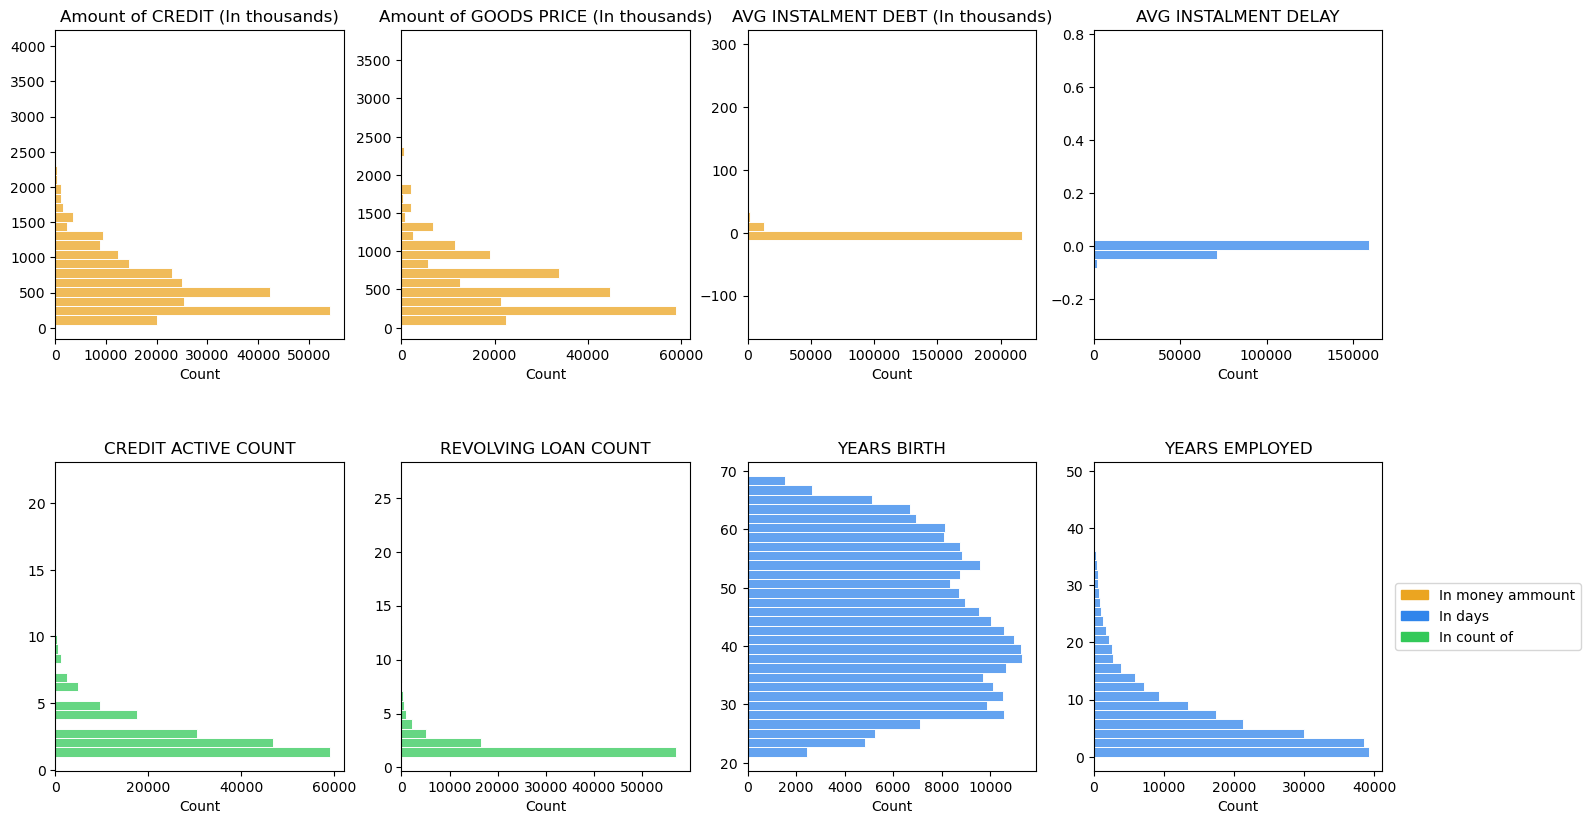

In [35]:
plot_numeric(plot_numeric_cols, train_data, color_palette)

#### 4.A.b Categorical features

1. Looking at the gender of applicants we can see that there are nearly twice as much females as males.
2. Only 120 people who applied have Academic degree. The vast majority  have either  Secondary / secondary special education type (174 700 ploaple) or Higher education (59 800 people) which hints that the applicants are majorly from working class.
3. Quite a lot of applicants are married people, roughly 4 times less people are single/not married. Interestingly over 12 000 people are widowed.
4. It looks not surprizing that over 40 000 peope are laborers, over 20 000 sales or core staff since the education hinted that working class takes the majority of applicants. Lucily that is not the case for everybody since around 20 000 of people are managers, around 10 000 are High skill tech staff, Accountants or Medicine staff. The occupation types that typically have high income such as Reality agents or IF staff are the minority of people who applied.
5. Looking at the organization type of applicants buisness entity, type not given  (XNA), and being self-employed stand out forming the majority of applicans. Other organization types are not that common.

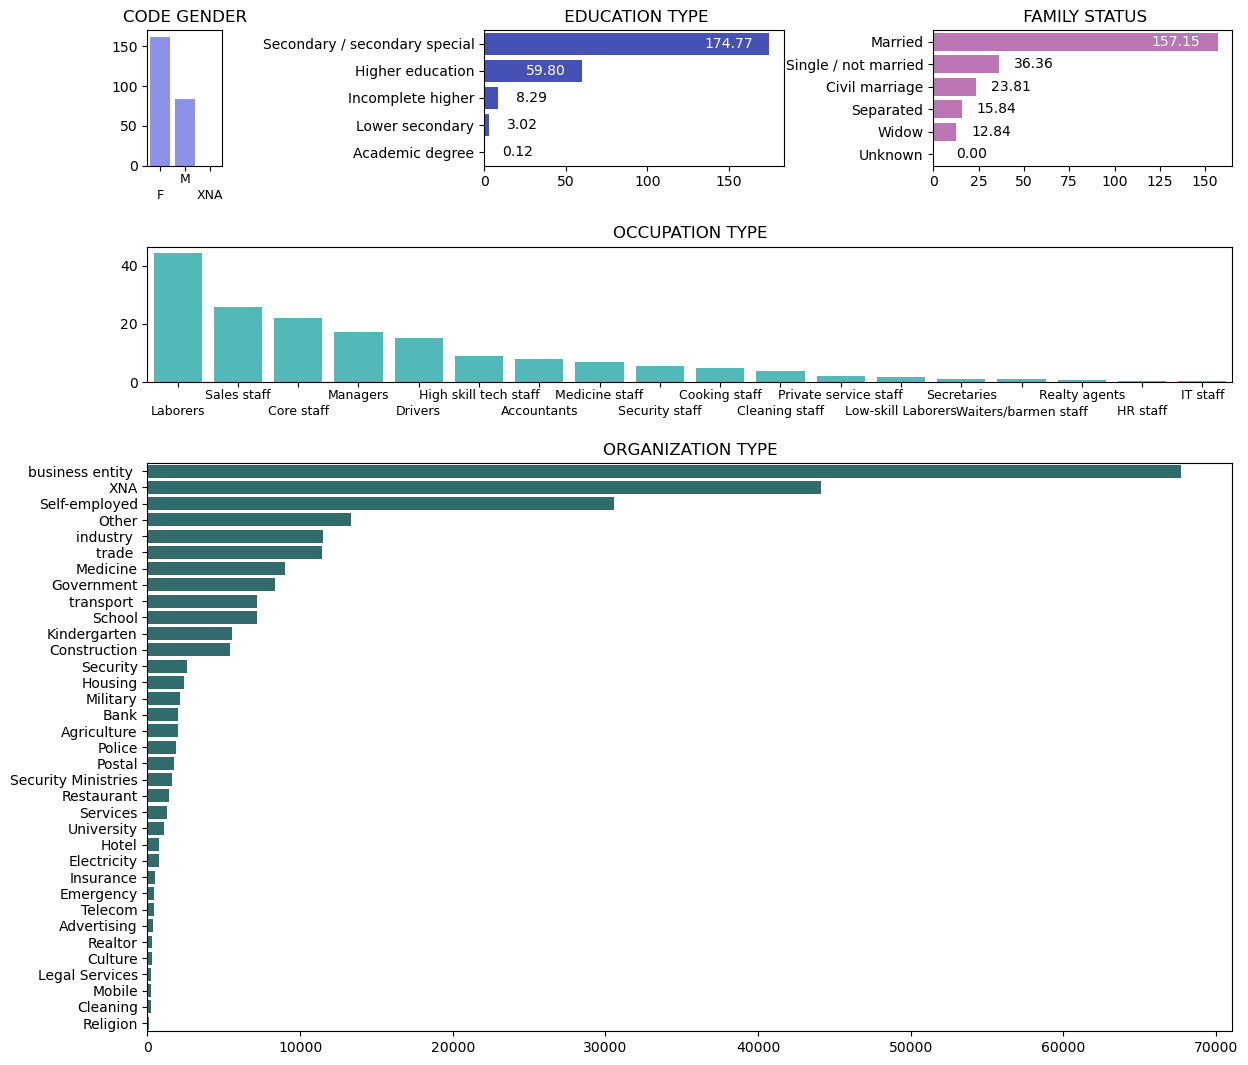

In [36]:
plot_categorical(plot_categoric_cols, train_data, color_palette)

### 4.B Feature relationship with TARGET

#### 4.B.a Clients overview: numeric features

Looking how distributions changed for the people with payment issues compared to the total applicants we see:
1. The shape of credit amount distributions seems very similar and the majority remains in the same interval. On the other hand the ammount of people who applied for around 500 000 and around 250 000 now seems to differ way less proving that the distribution trends are a bit different for the people with payment problems.
2. The same similarity in around 500 000 and around 250 000 amount counts can be as well seen for the goods price. Other ammounts seem to mimic the original distribution.
3. The average instalment debt of people having payment dificullties decreased from 363 overpayment to 174 unerpayment which hints that this might be a good predictor.
4. The average instalment delay for the people having payment problems is around 1 day lower which might be influanced by the fact that the longest delay is now around 100 days shorter and the longest advanced payment is 1000 days less ahead. At this point it is rather difficult to spaculate predictive power.
5. Both active credit count and revolving loan count seems to have very similar distribution and no new patterns seems to emerge for  the people having payment difficulties. Even though unseen in the plot the high counts of loans remain in low numbers indicating that potetially having many loans minght inreases chances of delays more than having a few.
6. In contrast when looking at the age of the people having payment difficulties a bit different distribution emerges. The differences in counts by age seems to be less drastic and the most common age shifts to be around 30  rather than 40. It does seem that the older you are the less difficulties of payments you face. The minimum and maximum age remains the same regarding having difficulties or not. Regardless, this trend hints that age might be a good predictor.
7. Similar trends as well is seen in the years of employment though the distribution is not that strongly different compared to age of applicant the people who have difficulties with payment are all been employed for 40 years or less which is different maximum value than the total maximum of dataset at 49 years. Though small change in distribution it can still benefit while making predictions.

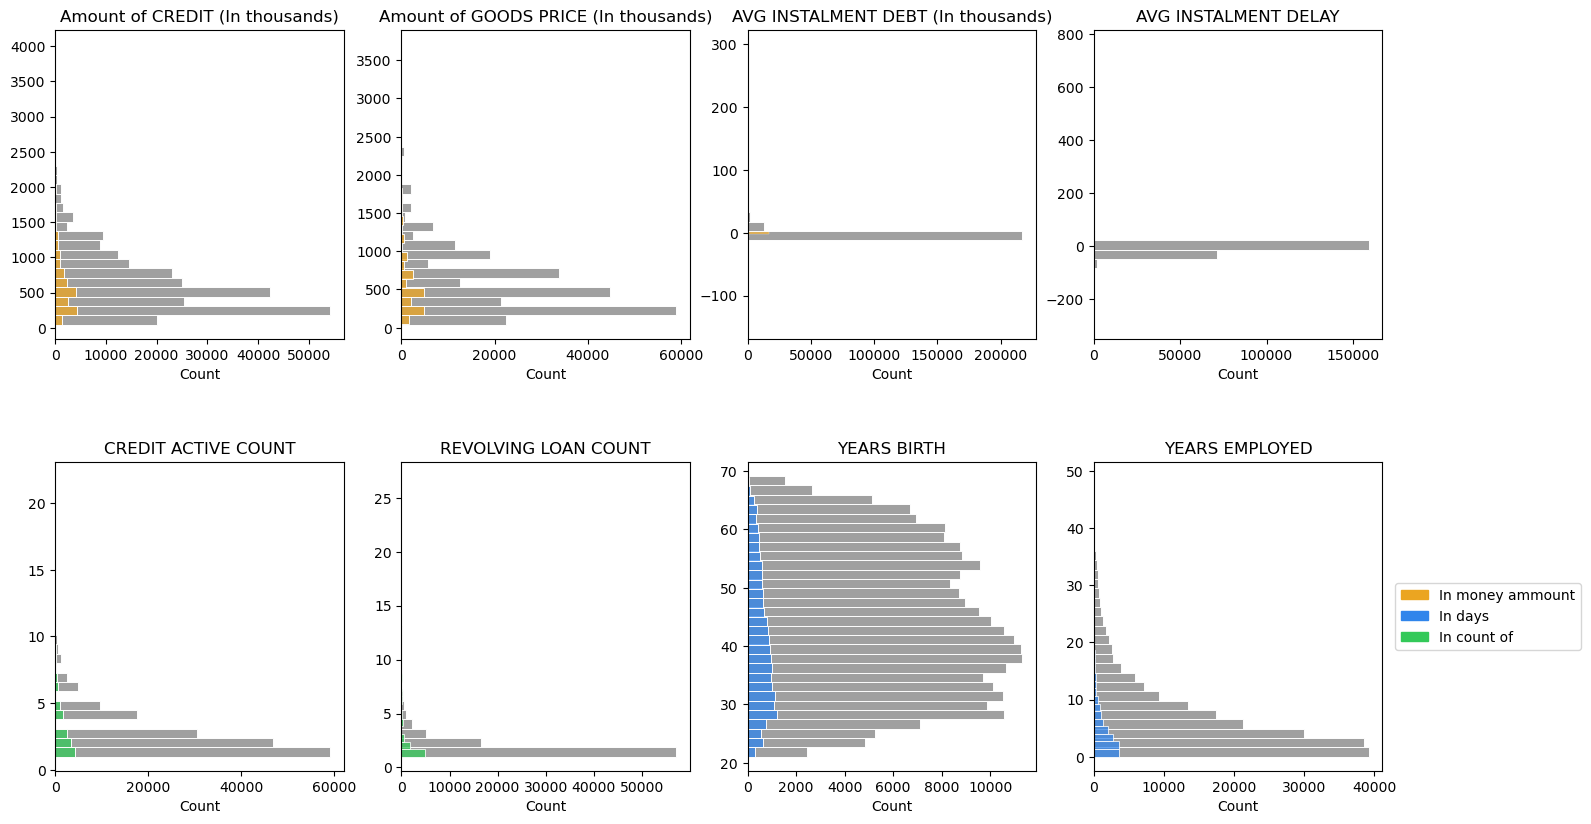

In [37]:
plot_numeric(
    plot_numeric_cols,
    train_data,
    color_palette,
    color_overwrite="grey",
    target_mask=(train_target == 1),
)

#### 4.B.b Categorical features

When looking at the difference in proportion of people who have payment difficulties amongst various categories of features some insights emerge:
1. Even though there are a lot more female applicants, male face difficulties in payment 3% more often. This indicates gender as a good predictor.
2. Between different education types we as well see 3-4% differences. The biggest contrast of about 10% is between people with academic degree and ones with lower secondary which in terms mean that one decreases chance of payment issues and the other increases. This feature as well seems to be as a good predictor.
3. Being in a civil marrige or single seems to increase chance of payment difficulties more than other statuses however not taht drastically.Other than being widowed there are no big contrasts in proportions thus this does not seem to be as strong predictor as others.
4. On the other hand the occupation type proportion fluctuations are rather dynamic, the highest chance being for low-skill laborers (18.1%) and the lowest for  accountans which is nearly 14% less. Laborers despite being the majority group of applicants have 10.5% of applicants with payment issues which is still at higher part compared to other categories. This feature might be a good predictor.
5. While organization type does have some fluctuations it seem less than occupation type. Most at risk of payment difficulties are people in Telecom and Security Ministries (11 and 11.4%). Other fiels do not differ that much and the highest count fields like buisness entity and self-employed have similar proportions of (8 and 8.4 %). The less risk is for the hotel field and advertising sector - 4.4% and 4.7%. It seems that only the 4 categories that are maximal and minimal in risk could be beneficial for predicting and might serve as a flag however the feature with all categories does not seem that beneficial.

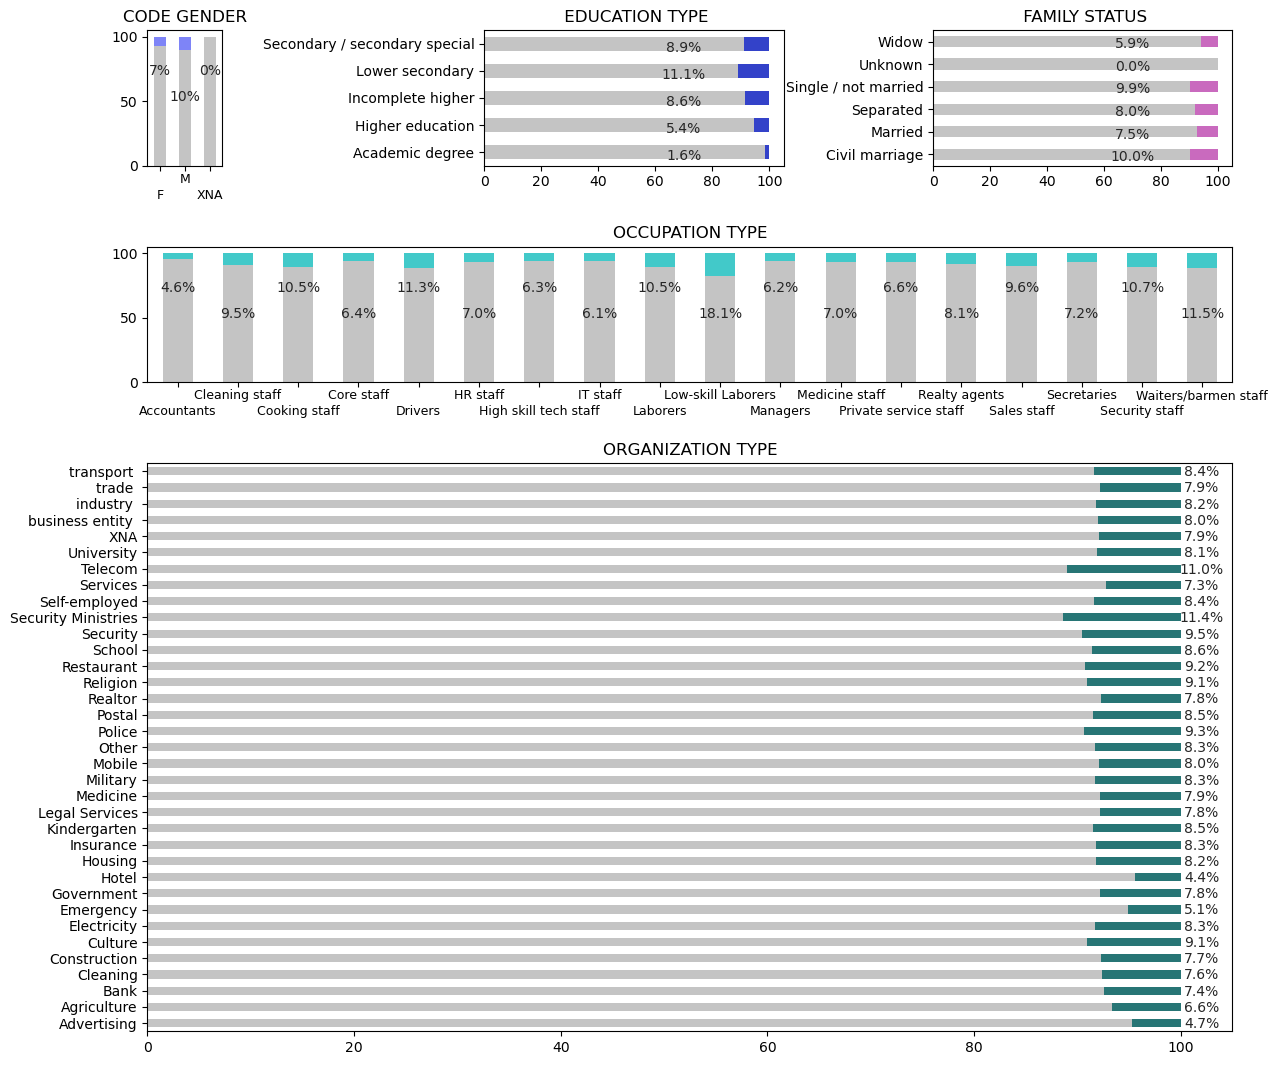

In [38]:
plot_cat_vs_target(
    color_palette, train_data, train_target, plot_categoric_cols
)

### 4.C Feature Correlations

Looking at the correlation matrix few features stand out with correlation of 1 raising big concern of multicollinearity:
* DAYS_EMPLOYED with NAME_INCOME_TYPE, ORGANIZATION_TYPE, FLAG_EMP_PHONE
* FLAG_EMP_PHONE with NAME_INCOME_TYPE, ORGANIZATION_TYPE
* REGION_RATING_CLIENT with REGION_RATING_CLIENT_W_CITY
* AMT_GOOD_PRICE with AMT_CREDIT

Other high correlation include:
* DAYS_BIRTH with DAYS_EMPLOYED, FLAG_EMP_PHONE having correlation value of 0.9
* ORGANIZATION_TYPE with NAME_INCOME_TYPE, OCCUPATION_TYPE having value of 0.8
* CODE_GENDER with OCCUPATION TYPE having value of 0.7
* DAYS_BIRTH with EXT_SOURCE_1, ORGANIZATION_TYPE having value of 0.6
* FLOORSMAX_MEDI with LIVINGAREA_MEDI having value of 0.6

Looking at the correlation value with the TARGET we see only weak correlation value of 0.2 with EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3.

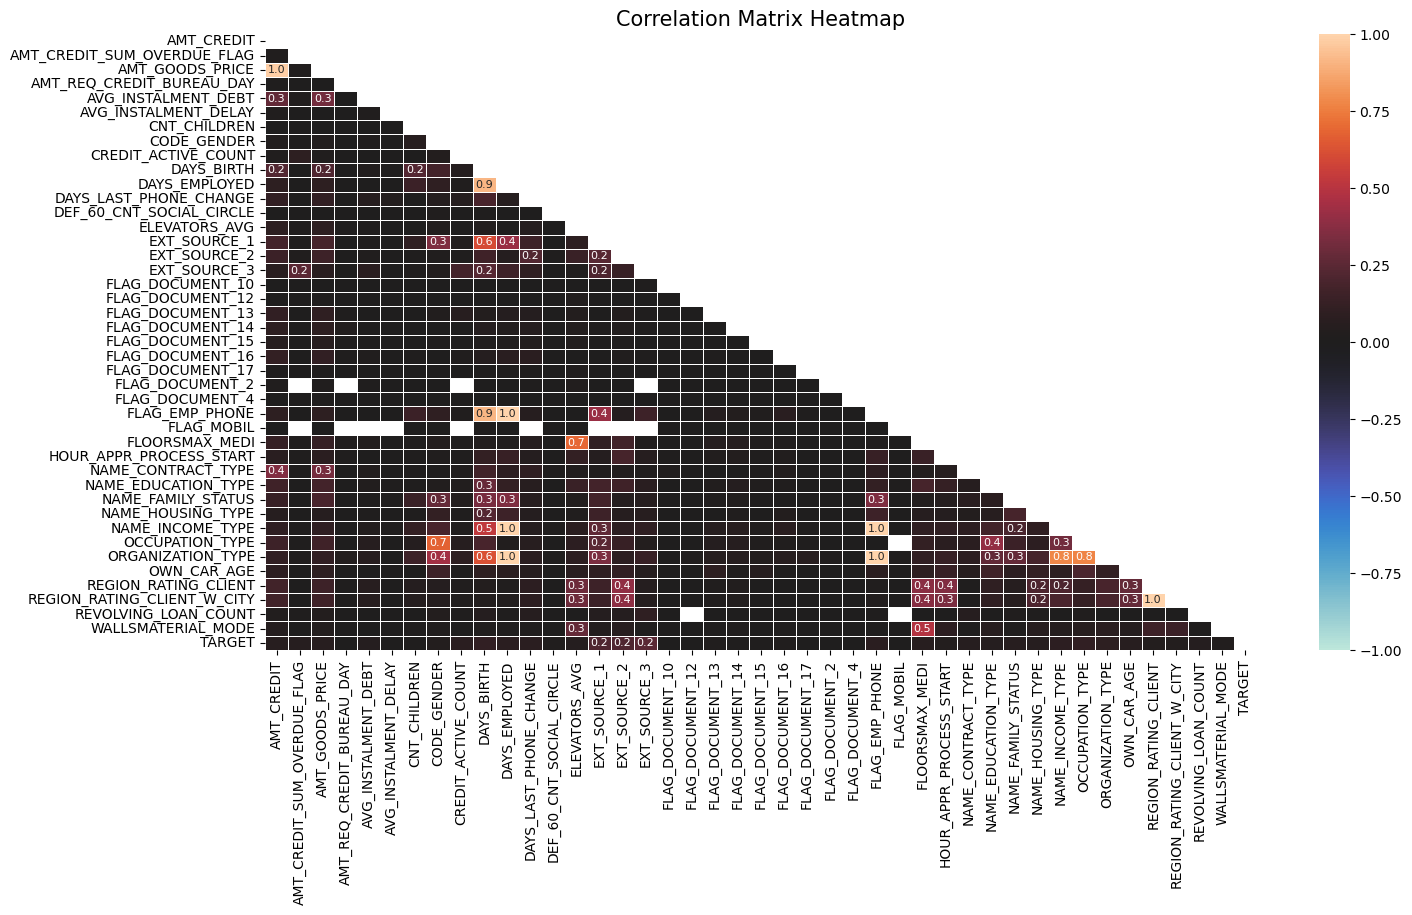

In [39]:
corr_cols = sorted(
    set(train_data.columns).intersection(set(rank_selected_columns))
)
train_corr = (
    train_data[list(corr_cols)]
    .join(train_target[train_data[list(corr_cols)].index])
    .copy()
)
corr_matrix = train_corr.phik_matrix(verbose=False)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 8))
annotations = corr_matrix.map(lambda x: f"{x:.1f}" if x > 0.2 else "")
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=annotations,
    cmap="icefire",
    vmin=-1,
    vmax=1,
    center=0,
    fmt="",
    linewidths=0.5,
    annot_kws={"size": 8},
)
plt.title("Correlation Matrix Heatmap", fontsize=15);

### 4.D Variance Inflation Factor (VIF)

The analysis of VIF has promted to make the following actions:
* The **removal of FLAG_MOBIL**	which has and enormously big VIF value of 4469.994.
    * **Consequance:** After its removal DAYS_EMPLOYED VIF value remained as 182.798 and FLAG_EMP_PHONEremained as 183.730. This indicates that further removal is necesarry. 
* The **removal of FLAG_EMP_PHONE** feature due to its extremely high VIF value of 183.730 which indicates multicollinearity with DAYS_EMPLOYED which has the VIF value of 182.798.
    * **Consequance:** After removal the VIF value of DAYS_EMPLOYED dropped to 1.186.
* The **removal of AMT_GOODS_PRICE** feature since it as well has extreme VIF value of 34.925. This might be due to multicollinearitu with AMT_CREDIT which has VIF of 34.867.
    * **Consequance:** After removing AMT_GOODS_PRICE the VIF of AMT_CREDIT decreased to 1.085.
* The **removal of REGION_RATING_CLIENT** since VIF value is 10.040 which indicates high multicollinearity and is higher than 	REGION_RATING_CLIENT_W_CITY value of 9.839.
    * **Consequance:** After removal the VIF of REGION_RATING_CLIENT_W_CITY decreased to 1.245.

After the above described removal stepstall y of features have VIF values in the **range from 1 o7 2**, which indicates **low multicollinearity**. </br>
This means variables are independent enough potentially making  **model not suffer from multicollinearity-related** issues.

In [40]:
select_cols = list(train_corr.select_dtypes(include=["float", "int"]).columns)
select_cols.remove("FLAG_MOBIL")
select_cols.remove("FLAG_EMP_PHONE")
select_cols.remove("AMT_GOODS_PRICE")
select_cols.remove("REGION_RATING_CLIENT")

X = add_constant(
    train_corr[select_cols].dropna().select_dtypes(include=["float", "int"])
)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    "{:.3f}".format(VIF(X.values, i)) for i in range(X.shape[1])
]
VIF_df = pd.DataFrame(vif_data)
VIF_drop = [
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "AMT_GOODS_PRICE",
    "REGION_RATING_CLIENT",
]
VIF_df.iloc[1:, :]

C:\Users\godak\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
1,AMT_CREDIT,1.084
2,AMT_CREDIT_SUM_OVERDUE_FLAG,1.024
3,AMT_REQ_CREDIT_BUREAU_DAY,1.019
4,AVG_INSTALMENT_DEBT,1.035
5,AVG_INSTALMENT_DELAY,1.028
6,CNT_CHILDREN,1.060
7,CREDIT_ACTIVE_COUNT,1.119
8,DAYS_BIRTH,1.673
9,DAYS_EMPLOYED,1.193
10,DAYS_LAST_PHONE_CHANGE,1.116


## 5. Hypothesis testing

### 5.A Categorical features

#### 5.A.a. Chi$^2$ test  test for diffrerence in proportion

Chi$^2$ test will be conducted for the 20 categorical features to reject or confirm the following hypothesis:
* $H_0$  $\pi_0 = \pi_1$: The proportion of people who were have payment difficulties is the same regardless categorical values:
    * 
* $H_A$  $\pi_0 \neq \pi_1$ The proportion of people who were have payment difficulties  is statistically different 

##### Results
As you can see below  statistically significant differences are found for all four categorical features except:
* FLAG_DOCUMENT_2,
* FLAG_DOCUMENT_4,
* FLAG_DOCUMENT_10,
* FLAG_DOCUMENT_12,
* FLAG_DOCUMENT_17
* FLAG_MOBIL (which will be removed due to multicollianrity with FLAG_EMP_PHONE that does show difference in proportion)

In other words these factors do seem to statistically signifinatly impact the proportion of people having payment difficulties or not. </br>
For these features the **null hypothesis is rejected** in favor of the alternative that the proportions are significantly different.</br>

In [41]:
bi_dict = {}
bi_signif = []

for feature in selected_cat_columns:
    contingency_table = pd.crosstab(train_data[feature], train_target)
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    p_value = round(p_value, 7)
    if p_value >= 0.05:
        rez = "Difference NOT found"
    else:
        rez = "Difference in proportion FOUND!"
    p_value = float(f"{p_value:.3f}")
    bi_dict[feature] = (chi2, round(p_value, 4), rez)
df = pd.DataFrame(
    data=bi_dict.values(),
    index=bi_dict.keys(),
    columns=["Chi2 Statistic", "p-value", "Interpretation"],
)
cat_no_diff_found = list(
    df[df["Interpretation"] == "Difference NOT found"].index
)
df

,Chi2 Statistic,p-value,Interpretation
CNT_CHILDREN,175.412159,0.000,Difference in proportion FOUND!
CODE_GENDER,733.021563,0.000,Difference in proportion FOUND!
FLAG_DOCUMENT_10,0.000000,1.000,Difference NOT found
FLAG_DOCUMENT_12,0.000000,1.000,Difference NOT found
FLAG_DOCUMENT_13,30.986541,0.000,Difference in proportion FOUND!
FLAG_DOCUMENT_14,18.015829,0.000,Difference in proportion FOUND!
FLAG_DOCUMENT_15,10.726648,0.001,Difference in proportion FOUND!
FLAG_DOCUMENT_16,30.645229,0.000,Difference in proportion FOUND!
FLAG_DOCUMENT_17,2.591147,0.107,Difference NOT found
FLAG_DOCUMENT_2,3.183263,0.074,Difference NOT found


#### 5.A.b 95% confidence interval of difference in proportion:

Oddly compared to the previous test we wee that all 95% confidence intervals show statistically signicicant difference in proportion since none of the intervals include 0 which would indicate no difference in proportions between people having payment issues or not. Even FLAG_MOBIL shows that the people that have the phone tend to have payment difficulties between 7.97 %	to 8.18 % more often 95% at the time.

In [118]:
sgnif_dict = {}
df_dict = {}
CI_data = train_data[selected_cat_columns].join(train_target)

for feature in selected_cat_columns:
    if len(train_data[CI_data[feature].notna()][feature].unique()) == 2:
        pos_group = CI_data[
            (CI_data[feature] == 1)
            | (CI_data[feature] == "Y")
            | (CI_data[feature] == "Yes")
        ]["TARGET"]
        neg_group = CI_data[
            (CI_data[feature] == 0)
            | (CI_data[feature] == "N")
            | (CI_data[feature] == "No")
        ]["TARGET"]
        interval = CI_95_proportion(pos_group, neg_group)
        sgnif_dict[feature] = interval
    else:
        pos_group = CI_data[
            (CI_data["TARGET"] == 1) & (train_data[feature].notna())
        ][feature]
        neg_group = CI_data[
            (CI_data["TARGET"] == 0) & (CI_data[feature].notna())
        ][feature]
        cat_result = CI_95_cat_diff(
            pos_group,
            neg_group,
            CI_data[CI_data[feature].notna()][feature].unique(),
        )
        df_dict[feature] = pd.DataFrame(
            data=[(f"{ci[0]} %", f"{ci[1]} %") for ci in cat_result.values()],
            index=cat_result.keys(),
            columns=[" CI upper bound", "CI lower bound"],
        )

df = pd.DataFrame(
    data=[(f"{ci[0]} %", f"{ci[1]} %") for ci in sgnif_dict.values()],
    index=sgnif_dict.keys(),
    columns=["CI upper bound", "CI lower bound"],
)
display(df)

C:\Users\godak\Desktop\DS study\Module 3\Sprint 4\CI_95.py:25: RuntimeWarning: invalid value encountered in scalar divide
  p_pos_group = x_pos_group / n_pos_group
C:\Users\godak\Desktop\DS study\Module 3\Sprint 4\CI_95.py:26: RuntimeWarning: invalid value encountered in scalar divide
  p_neg_group = x_neg_group / n_neg_group


,CI upper bound,CI lower bound
FLAG_DOCUMENT_10,-8.18 %,-7.97 %
FLAG_DOCUMENT_12,-8.18 %,-7.97 %
FLAG_DOCUMENT_13,-6.45 %,-4.21 %
FLAG_DOCUMENT_14,-5.75 %,-2.99 %
FLAG_DOCUMENT_15,-7.22 %,-3.51 %
FLAG_DOCUMENT_16,-3.94 %,-2.2 %
FLAG_DOCUMENT_17,-9.62 %,-3.25 %
FLAG_DOCUMENT_2,-7.12 %,45.52 %
FLAG_DOCUMENT_4,-8.18 %,-7.97 %
FLAG_EMP_PHONE,3.05 %,3.54 %


##### If we look at the features containing more tha 2 categories we see that:
1. HOUR_APPR_PROCESS_START has more insignificant categories than significant one (the ones not including 0%). This should not be included as a strong predictor.
2. NAME_EDUCATION_TYPE  on the other hand shows that those who completed only Secondary / secondary special education level have from 7.47 % to	8.67 % more risk to have paymant difficulties in contrast with those who completed Higher education that have	from 8.23 % to 9.32 % LESS risk to have payment difficulties. Having these 2 categories as one-hot encoded could benefit the prediction.
3. Looking at NAME_FAMILY_STATUS we see the same insight as from the charts. The differences and magnitude in the proportion differences is rather small confirming that this is a weak predictor.
4. NAME_HOUSING_TYPE is also similar to NAME_FAMILY_STATUS feature in having weak differences.
5. However, rather interesting trends can be observed for the NAME_INCOME_TYPE feature. Those who are working have increased risk from 9.49 % to 10.91 %, although those who are Pensioner	have decreased risk from 6.08 % to 7.04 % of having payment difficulties. Other categories do not show significant difference or it is rather small.
6. OCCUPATION_TYPE was also reviewed in the plots above however 95% CI does not show that the differences are as high as the plots. at most the highest risk is for Laborers - from 4.87 %	to 6.42 %.
7. ORGANIZATION_TYPE was chosen to be depicted as grouped in the plots above, here it is as originally presented. Even though the difference is very small between the groups. At most the risk is higher for ones  being self-employed (3.06 % - 4.11 %) or Business Entity Type 3	(2.95 % - 4.21 %).
8.  REGION_RATING_CLIENT and REGION_RATING_CLIENT_W_CITY as seen before are highly correlated so not surprising that the intervals are very similar - decreasing risk for the 1 reching up to 5% and the highest risk for 3 reaching up to 7%.
9. WALLSMATERIAL_MODE most influantial category is Panel which seems to decrease the risk of payment difficulties from 3.11 % to 5.27 %. Other materials do not seem to have a big impact.pecial	

In [43]:
for i, feature in enumerate(df_dict.keys(), 1):
    print(f"\n\n{i}. {feature}:")
    display_df = df_dict[feature].sort_index()
    display(display_df)



1. HOUR_APPR_PROCESS_START:


,CI upper bound,CI lower bound
0,-0.01 %,0.03 %
1,-0.02 %,0.03 %
2,-0.03 %,0.07 %
3,-0.07 %,0.11 %
4,-0.06 %,0.19 %
5,0.29 %,0.65 %
6,0.53 %,0.98 %
7,0.58 %,1.12 %
8,0.35 %,1.02 %
9,-0.34 %,0.49 %




2. NAME_EDUCATION_TYPE:


,CI upper bound,CI lower bound
Academic degree,-0.06 %,-0.03 %
Higher education,-9.32 %,-8.23 %
Incomplete higher,-0.02 %,0.52 %
Lower secondary,0.31 %,0.68 %
Secondary / secondary special,7.47 %,8.67 %




3. NAME_FAMILY_STATUS:


,CI upper bound,CI lower bound
Civil marriage,2.07 %,3.0 %
Married,-5.35 %,-3.93 %
Separated,-0.43 %,0.28 %
Single / not married,3.17 %,4.28 %
Unknown,-0.0 %,0.0 %
Widow,-1.83 %,-1.27 %




4. NAME_HOUSING_TYPE:


,CI upper bound,CI lower bound
Co-op apartment,-0.05 %,0.13 %
House / apartment,-3.84 %,-2.84 %
Municipal apartment,-0.07 %,0.49 %
Office apartment,-0.3 %,-0.06 %
Rented apartment,0.69 %,1.12 %
With parents,2.01 %,2.74 %




5. NAME_INCOME_TYPE:


,CI upper bound,CI lower bound
Businessman,-0.01 %,-0.0 %
Commercial associate,-2.11 %,-0.91 %
Maternity leave,-0.0 %,0.0 %
Pensioner,-7.04 %,-6.08 %
State servant,-2.46 %,-1.81 %
Student,-0.01 %,-0.0 %
Unemployed,-0.0 %,0.04 %
Working,9.49 %,10.91 %




6. OCCUPATION_TYPE:


,CI upper bound,CI lower bound
Accountants,-2.69 %,-2.15 %
Cleaning staff,-0.05 %,0.46 %
Cooking staff,0.3 %,0.91 %
Core staff,-4.43 %,-3.43 %
Drivers,2.19 %,3.25 %
HR staff,-0.14 %,0.02 %
High skill tech staff,-2.01 %,-1.36 %
IT staff,-0.15 %,-0.01 %
Laborers,4.87 %,6.42 %
Low-skill Laborers,0.93 %,1.4 %




7. ORGANIZATION_TYPE:


,CI upper bound,CI lower bound
Advertising,-0.04 %,0.07 %
Agriculture,0.15 %,0.44 %
Bank,-0.39 %,-0.17 %
Business Entity Type 1,-0.21 %,0.19 %
Business Entity Type 2,-0.01 %,0.53 %
Business Entity Type 3,2.95 %,4.21 %
Cleaning,-0.01 %,0.09 %
Construction,0.89 %,1.4 %
Culture,-0.08 %,0.01 %
Electricity,-0.11 %,0.05 %




8. REGION_RATING_CLIENT:


,CI upper bound,CI lower bound
1,-4.91 %,-4.19 %
2,-2.57 %,-1.27 %
3,5.87 %,7.06 %




9. REGION_RATING_CLIENT_W_CITY:


,CI upper bound,CI lower bound
1,-5.17 %,-4.43 %
2,-2.35 %,-1.07 %
3,5.93 %,7.09 %




10. WALLSMATERIAL_MODE:


,CI upper bound,CI lower bound
Block,-0.49 %,0.57 %
Mixed,-0.19 %,0.35 %
Monolithic,-0.61 %,-0.21 %
Others,-0.07 %,0.41 %
Panel,-5.27 %,-3.11 %
"Stone, brick",1.59 %,3.78 %
Wooden,1.14 %,2.1 %


### 5.B Numeric features

### 5.B.a Levene's test :
The test shows that the variances of continuos features having payment difficulties and not groups are NOT equal except for AMT_REQ_CREDIT_BUREAU_DAY, AVG_INSTALMENT_DELAY. </br>
Apart from those feature the assumptions of t-test do not pass and this will be taken into account when conducting further tests.

In [44]:
lev_dict = {}
float_cols = set(rank_selected_columns) - set(selected_cat_columns)

hipt_data = train_data[list(float_cols)].join(train_target)

for feature in float_cols:
    stat, p_levene = stats.levene(
        hipt_data[(hipt_data["TARGET"] == 1) & (hipt_data[feature].notna())][
            feature
        ],
        hipt_data[(hipt_data["TARGET"] == 0) & (hipt_data[feature].notna())][
            feature
        ],
    )
    if p_levene >= 0.05:
        variance = "Variances are equal!"
    else:
        variance = "Variances are NOT equal"
    lev_dict[feature] = (stat, round(p_levene, 4), variance)

df = pd.DataFrame(
    data=lev_dict.values(),
    index=lev_dict.keys(),
    columns=["Levene's test statistic", "p-value", "Interpretation"],
)
df.sort_index()

,Levene's test statistic,p-value,Interpretation
AMT_CREDIT,674.701866,0.0000,Variances are NOT equal
AMT_CREDIT_SUM_OVERDUE_FLAG,246.536005,0.0000,Variances are NOT equal
AMT_GOODS_PRICE,782.461045,0.0000,Variances are NOT equal
AMT_REQ_CREDIT_BUREAU_DAY,2.320071,0.1277,Variances are equal!
AVG_INSTALMENT_DEBT,26.956485,0.0000,Variances are NOT equal
AVG_INSTALMENT_DELAY,0.359356,0.5489,Variances are equal!
CREDIT_ACTIVE_COUNT,581.815827,0.0000,Variances are NOT equal
DAYS_BIRTH,175.914116,0.0000,Variances are NOT equal
DAYS_EMPLOYED,550.289438,0.0000,Variances are NOT equal
DAYS_LAST_PHONE_CHANGE,577.497857,0.0000,Variances are NOT equal


#### 5.B.b One-sided t-test:

 * $H_0:  \mu_1 = \mu_0$ There is no difference between average values of those who have payment difficulties ($\mu_1$) and who do not ($\mu_0$) of the numeric features.
 <br>
 * $H_A :  \mu_0 > \mu_1$ : Those who do NOT have payment difficulties have higher average value ($\mu_0$)
 * Only if the p value sis equal to 1 we switch to this alternative hypothesis:
     * $H_A :  \mu_0 < \mu_1$ : Those who have payment difficulties have higher average value ($\mu_1$) 
  <br> <br>

the vast majority of the features show there is statistical evidence to reject the null hypothesis in favor of alternative that the mean is statistically significantly higher for one goup or the other making the features  **a valid predictors of being payment difficulties.**
AMT_REQ_CREDIT_BUREAU_DAY stands out by not haveing statistical evidence to reject the null hypothesis of the means being equal. 

In [45]:
one_dict = {}
for feature in float_cols:
    t_statistic, p_value = stats.ttest_ind(
        hipt_data[(hipt_data["TARGET"] == 1) & (hipt_data[feature].notna())][
            feature
        ],
        hipt_data[(hipt_data["TARGET"] == 0) & (hipt_data[feature].notna())][
            feature
        ],
        alternative="less",
        equal_var=False,
    )
    if (p_value >= 0.05) & (round(p_value, 5) != 1.0):
        result = "The means are statisticaly equal"
    elif (p_value <= 0.05) & (round(p_value, 5) != 1.0):
        result = f"{feature} mean is higher for those who did NOT delay"
    elif round(p_value, 2) == 1.0:
        t_statistic, p_value = stats.ttest_ind(
            hipt_data[
                (hipt_data["TARGET"] == 1) & (hipt_data[feature].notna())
            ][feature],
            hipt_data[
                (hipt_data["TARGET"] == 0) & (hipt_data[feature].notna())
            ][feature],
            alternative="greater",
            equal_var=False,
        )
        if p_value >= 0.05:
            result = "The means are statisticaly equal"
        else:
            result = (
                f"{feature} mean is higher for those who delay on payments"
            )
    one_dict[feature] = (round(t_statistic, 2), round(p_value, 7), result)

df = pd.DataFrame(
    data=one_dict.values(),
    index=one_dict.keys(),
    columns=["T-test statistic", "p-value", "Interpretation"],
)
pd.set_option("display.max_colwidth", None)
display(df)
pd.reset_option("display.max_colwidth")

,T-test statistic,p-value,Interpretation
EXT_SOURCE_1,-52.54,0.000000,EXT_SOURCE_1 mean is higher for those who did NOT delay
AVG_INSTALMENT_DELAY,11.05,0.000000,AVG_INSTALMENT_DELAY mean is higher for those who delay on payments
FLOORSMAX_MEDI,-16.31,0.000000,FLOORSMAX_MEDI mean is higher for those who did NOT delay
AMT_GOODS_PRICE,-23.03,0.000000,AMT_GOODS_PRICE mean is higher for those who did NOT delay
ELEVATORS_AVG,-13.11,0.000000,ELEVATORS_AVG mean is higher for those who did NOT delay
AMT_REQ_CREDIT_BUREAU_DAY,1.55,0.938947,The means are statisticaly equal
EXT_SOURCE_3,-75.82,0.000000,EXT_SOURCE_3 mean is higher for those who did NOT delay
EXT_SOURCE_2,-71.56,0.000000,EXT_SOURCE_2 mean is higher for those who did NOT delay
AMT_CREDIT,-17.48,0.000000,AMT_CREDIT mean is higher for those who did NOT delay
CREDIT_ACTIVE_COUNT,21.32,0.000000,CREDIT_ACTIVE_COUNT mean is higher for those who delay on payments


#### 5.B.c 95% confidence interval (CI) of mean difference

##### Straight away we can spot more significant mean differences of the following features:
* AMT_GOODS_PRICE mean being -54124.51 and CI [-58730.7896, -49518.2301]
* AMT_CREDIT mean being -45537.39 and CI [-50644.5294, -40430.2506]
* DAYS_BIRTH mean being 1272.69 (roughly 3.49 years) and CI [1211.7028, 1333.6731]
* AVG_INSTALMENT_DEBT mean being -586.79 and CI [-643.2012, -530.378]
* DAYS_LAST_PHONE_CHANGE mean being 63.26 and CI [152.1943, 174.3354]
* 
DAYS_EMPLOYE mean being 	-23488.5 (roughly 64.35 years) and CI 	[-25245.1283, -21732.0394]
</br></br>
Other numeric features show ether very small difference or CI include 0.

In [46]:
mean_dict = {}
signif_numeric_features = []
for feature in float_cols:
    pos_group = hipt_data[
        (hipt_data["TARGET"] == 1) & (hipt_data[feature].notna())
    ][feature]
    neg_group = hipt_data[
        (hipt_data["TARGET"] == 0) & (hipt_data[feature].notna())
    ][feature]
    mean_diff, lower, upper = CI_95_mean_diff(pos_group, neg_group)
    mean_dict[feature] = (mean_diff, f"[{lower}, {upper}]")
    if upper - lower > 0:
        signif_numeric_features.append(feature)

df = pd.DataFrame(
    data=mean_dict.values(),
    index=mean_dict.keys(),
    columns=["Mean difference", "95% confidence interval"],
)
df = df.rename_axis("Feature")
df

,Mean difference,95% confidence interval
Feature,,
EXT_SOURCE_1,-0.12,"[-0.1294, -0.1201]"
AVG_INSTALMENT_DELAY,1.02,"[0.8394, 1.2013]"
FLOORSMAX_MEDI,-0.02,"[-0.0277, -0.0218]"
AMT_GOODS_PRICE,-54124.51,"[-58730.7896, -49518.2301]"
ELEVATORS_AVG,-0.02,"[-0.021, -0.0155]"
AMT_REQ_CREDIT_BUREAU_DAY,0.00,"[-0.0004, 0.0031]"
EXT_SOURCE_3,-0.13,"[-0.1334, -0.1267]"
EXT_SOURCE_2,-0.11,"[-0.115, -0.1089]"
AMT_CREDIT,-45537.39,"[-50644.5294, -40430.2506]"


#### 5.B.d Cohen's d test:

The effect size shown by the results is a bit surprizing:
* Medium effect is  detected for features that showed rather small difference however having CI not include 0:
    * EXT_SOURCE_1
    * EXT_SOURCE_2
    * EXT_SOURCE_3
* Small effect:
    * CREDIT_ACTIVE_COUNT
    *  DAYS_BIRTH which seemed to have quite noticible difference between the groups
    *  DAYS_LAST_PHONE_CHANGE
 
Regardless the effect size these are great results since all of these columns have been selected as significant by the ranking method we have conducted previously supporting the method with additional statistics.

In [47]:
cohen_d_dict = {}
for feature in signif_numeric_features:
    mean_1 = np.mean(hipt_data[hipt_data["TARGET"] == 1][feature])
    mean_0 = np.mean(hipt_data[hipt_data["TARGET"] == 0][feature])
    std_1 = np.std(hipt_data[hipt_data["TARGET"] == 1][feature], ddof=1)
    std_0 = np.std(hipt_data[hipt_data["TARGET"] == 0][feature], ddof=1)
    pooled_std = np.sqrt((std_1**2 + std_0**2) / 2)
    cohen_d = (mean_1 - mean_0) / pooled_std
    if abs(round(cohen_d, 2)) < 0.2:
        efect_size = "No Effect"
    elif 0.2 <= abs(round(cohen_d, 2)) < 0.5:
        efect_size = "Small Effect"
    elif 0.5 <= abs(round(cohen_d, 2)) < 0.8:
        efect_size = "Medium Effect"
    else:
        efect_size = "Large Effect"
    cohen_d_dict[feature] = round(cohen_d, 2), efect_size

df = pd.DataFrame(
    data=cohen_d_dict.values(),
    index=cohen_d_dict.keys(),
    columns=["Cohen's d coeficient", "Effect size"],
)
df

,Cohen's d coeficient,Effect size
EXT_SOURCE_1,-0.60,Medium Effect
AVG_INSTALMENT_DELAY,0.08,No Effect
FLOORSMAX_MEDI,-0.18,No Effect
AMT_GOODS_PRICE,-0.16,No Effect
ELEVATORS_AVG,-0.14,No Effect
AMT_REQ_CREDIT_BUREAU_DAY,0.01,No Effect
EXT_SOURCE_3,-0.66,Medium Effect
EXT_SOURCE_2,-0.56,Medium Effect
AMT_CREDIT,-0.12,No Effect
CREDIT_ACTIVE_COUNT,0.20,Small Effect


## 6. EDA conclusions

#### Data structure and quality:
##### 1. Missing Values

* Prevalence: Over half of the dataset (67/121 columns) has missing values, with some columns exceeding  69.87% missingness. Patterns in missing values suggest redundancy among features (e.g., _MEDI, _AVG, _MODE variations).
* Impact on Rows: Removing rows with missing values would result in a significant loss (97.2%) of data, though these rows only represent 7.9% of positive cases.
* Datasets with high percentages of missing values (e.g., credit_card_balance and bureau_balance) were discarded, as the utility of these features during training would be limited.
* Missing values in other columns (up to 6% in training data and 2% in test data) are addressed using imputation.

##### 2. Outliers
Features with over 50% missing data or highly skewed distributions were excluded from outlier detection.
Removing outliers (up to 3%) would result in a loss of only 6.51% of the data, but they were retained to preserve sample size.

##### 3. Class Imbalance
The dataset is significantly imbalanced, with only 8.07% positive cases (having payment issues).
A Chi-Square test confirmed the presence of Sample Ratio Mismatch (SRM), emphasizing the need for techniques like class weighting.

#### Initial feature selection
##### 1. Feature Engineering
In total 16 new features derived from auxiliary datasets (e.g., bureau, POS_CASH_balance)  offering nuanced indicators of financial health, debt patterns, and repayment behaviors, enhancing prediction capacity. Out of them based on statistical test these 5 were selected:
* From installments_payments:
    * most promissing features were AVG_INSTALMENT_DEBT and AVG_INSTALMENT_DELAY measure financial discrepancies and delays.
* From bureau:
    * CREDIT_ACTIVE_COUNT reflect credit activity.
    * AMT_CREDIT_SUM_OVERDUE_FLAG reflecting if such issues were present before
* From application_prev:
    * REVOLVING_LOAN_COUNT reflecting client's history
* From POS_CASH_balance:
    * none were deemed usefull

##### 2. Feature Selection
A combination of statistical and machine learning-based methods was employed:
* Numeric Features:
    * Techniques: Signal-to-Noise Ratio, Spearman Correlation, Mutual Information, and XGBoost feature importance.
    * Final Selection: 19/85 columns, representing 22.35%.
* Categorical Features:
    * Techniques: Odds Ratio, Mutual Information, Chi-Square Test, Weight of Evidence.
    * Final Selection: 24/53 columns, representing 45.28%.
</br></br>
Total Features Selected: 43 out of 136 columns, including 5 engineered features: AVG_INSTALMENT_DEBT, AMT_CREDIT_SUM_OVERDUE_FLAG, REVOLVING_LOAN_COUNT, AVG_INSTALMENT_DELAY, and CREDIT_ACTIVE_COUNT. The selected features include critical predictors like DAYS_BIRTH, EXT_SOURCE_1/2/3, CREDIT_ACTIVE_COUNT, and AMT_CREDIT. 


#### Visual and Multicollinearity  investigation 
##### 1. General Feature Analysis:
* Numeric Features:
    * Key predictors like Amount of Credit, Average Installment Debt, Age and Years Employed exhibit distinct trends between the general population and individuals with payment difficulties.
* Categorical Features:
    * Significant differences in proportions are observed for categories like Gender, Education Type, Occupation Type, and Organization Type. These should be prioritized for inclusion in modeling due to their predictive potential.
    * Some categorical variables (e.g., FLAG_DOCUMENT_2, FLAG_DOCUMENT_4) show no statistical difference, indicating low utility for prediction.

##### 2. Relationship with the Target:
Features like EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 have weak correlations (≈0.2) with the target but might still provide predictive value in ensemble models or non-linear algorithms.
Stronger trends are evident for Average Installment Debt, Age, and Education Type, which exhibit notable differences in distribution or proportions.

##### 3. Multicollinearity and VIF Analysis:
High multicollinearity was effectively managed by removing features like:
* FLAG_MOBIL
* FLAG_EMP_PHONE
* AMT_GOODS_PRICE
* REGION_RATING_CLIENT
Remaining features have VIF values between 1 and 2, ensuring minimal multicollinearity. This step significantly improves model interpretability and robustness.

#### Hypothesis testing and Confidence intervals
The tests seem to support the initial choise of features as well though some of them showing more potential some less potential of predictive power. Here are the main findings:
* Categorical Features:
    * Significant Predictors: CNT_CHILDREN, CODE_GENDER, FLAG_DOCUMENT_13-16, FLAG_EMP_PHONE, HOUR_APPR_PROCESS_START, NAME_CONTRACT_TYPE, NAME_EDUCATION_TYPE, NAME_INCOME_TYPE, OCCUPATION_TYPE, ORGANIZATION_TYPE, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WALLSMATERIAL_MODE.
    * Weak Predictors: FLAG_DOCUMENT_2, 4, 10, 12, 17, and NAME_HOUSING_TYPE, NAME_FAMILY_STATUS showed small or no differences in proportions.
    * Notable Trends:
        * Secondary education increases risk by 7.47%-8.67%, while higher education decreases it by 8.23%-9.32%.
        * Pensioners have a lower risk (6.08%-7.04%), while working individuals face higher risk (9.49%-10.91%).
        * Laborers and self-employed individuals are at slightly higher risk.
* Numerical Features:
    * Significant Predictors:
    * Features with higher means for those who did not delay: EXT_SOURCE_1-3, FLOORSMAX_MEDI, AMT_GOODS_PRICE, ELEVATORS_AVG, AVG_INSTALMENT_DEBT.
    * Features with higher means for those who delayed: CREDIT_ACTIVE_COUNT, DAYS_BIRTH, AVG_INSTALMENT_DELAY, AMT_CREDIT_SUM_OVERDUE_FLAG, OWN_CAR_AGE, REVOLVING_LOAN_COUNT.
    * Weak Predictor: AMT_REQ_CREDIT_BUREAU_DAY showed no statistical difference in means.
    * Age Trend: Older individuals tend to delay more often.
    * Confidence Intervals:
        * Most features showed statistically significant differences, confirming their predictive potential, with trends aligning with hypothesis testing results.




## 7. Preprocessing

###  7.A Preprocessing pipeline creation
  
The goal is to create preprocessing pipeline which would have the following steps:
1. **Feature Engineering**: includes creation of the above mentioned features
2. **Encoding**:
    * encode binary categarical values using Ordinal encoder
    * encode columns having more than 2 categories using One-Hot encoding
    * encode ORGANIZATION_TYPE using the mixture of encodings:
        * One-hot encoding for types without sybtype (31 types)
        * The following industries will form these distinct columns:
            * ORGANIZATION_TYPE_business_entity containing values of 1, 2 and 3,
            * ORGANIZATION_TYPE_transport containg: 1, 2, 3, 4
            * ORGANIZATION_TYPE_industry containing: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
            * ORGANIZATION_TYPE_trade containing : 1, 2, 3, 4, 5, 6, 7 
4. **Ensure column order**: Since encoding disrupts the column order I must restori it to original before imputation
5.  **Interactive Imputer**: Uses the data to impute the missing values using other columns to find the closest value
6. **Preprocess for one-hot encoder**: Corrects the column names that were renamed and rounds the encoded columns above in additionround to integer values since the inputation results are float. Decode the categorical columns that will be one-hot encoded.
7. **One-hot encoder**: Since there is no clear order for most columnscolumns after encoding and imputation they are one-hot encoded instead. 
8. **Standard Scaler**: To make sure that the models run fact ans smoothly Standard Scaler is used.

In [48]:
ordinal_enc_cols = []
one_hot_enc_cols = []
for col in (
    train_data[rank_selected_columns].select_dtypes(include=["object"]).columns
):
    if len(train_data[train_data[col].notna()][col].unique()) > 2:
        one_hot_enc_cols.append(col)
    else:
        ordinal_enc_cols.append(col)
one_hot_enc_cols.remove("ORGANIZATION_TYPE")

categories = [
    train_data[train_data[col].notna()][col].unique().tolist()
    for col in one_hot_enc_cols
]

In [49]:
bi_ord_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)
bi_ord_encoder_step = ColumnTransformer(
    transformers=[
        ("Binaly Ordinal encoder", bi_ord_encoder, ordinal_enc_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

cat_ord_encoder = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=np.nan,
)
cat_ord_encoder_step = ColumnTransformer(
    transformers=[
        ("Category Ordinal encoder", cat_ord_encoder, one_hot_enc_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

one_hot_encoder = OneHotEncoder(
    sparse_output=False, handle_unknown="ignore", dtype=np.int32
)
one_hot_encoder_step = ColumnTransformer(
    transformers=[
        (
            "One-Hot encoder",
            one_hot_encoder,
            one_hot_enc_cols,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

prep_one_hot = DecodeCatOrdEncoding(
    one_hot_enc_cols, cat_ord_encoder_step, categories
)

In [50]:
imputer = IterativeImputer(
    random_state=RANDOM_STATE, initial_strategy="median", max_iter=50
).set_output(transform="pandas")
select_ranked = DropUnselectedColumns(rank_selected_columns, VIF_drop)
scale_col_mask = list(set(rank_selected_columns) - set(VIF_drop))
cols_to_scale = list(
    train_data[scale_col_mask].select_dtypes(include=["float"]).columns
)
for col in cols_to_scale:
    if (col[-5:] == "COUNT") or (col[-5:] == "_FLAG"):
        cols_to_scale.remove(col)

standard_scaler = StandardScaler()
standard_scaler_step = ColumnTransformer(
    transformers=[
        (
            "Standard Scaler Transformer",
            standard_scaler,
            cols_to_scale,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

preprocess_pipeline = Pipeline(
    steps=[
        (
            "Feature_Engineering",
            FeatureExtractionTransformer(
                installments_payments=installments_payments,
                bureau=bureau,
                application_prev=application_prev,
                POS_CASH_balance=POS_CASH_balance,
                selected_columns=engineered_and_selected,
            ),
        ),
        ("Column selector", select_ranked),
        ("Binalry_Ordinal_Encoder", bi_ord_encoder_step),
        ("Category_Ordinal_Encoder", cat_ord_encoder_step),
        ("Encode_Organization_type", EncodeOrganizationType()),
        ("Ensure column order", ReorderColumns(EncodeOrganizationType)),
        ("Interactive_Imputer", imputer),  # 7
        ("Preprocess for one-hot encoding", prep_one_hot),
        ("One-hot encoder", one_hot_encoder_step),  # 4
        (
            "Standard Scaler",
            standard_scaler_step,
        ),
    ],
    verbose=True,
)

##### Export lists used for preprocessing pipeline

In [51]:
with open("ordinal_enc_cols.pkl", "wb") as f:
    pickle.dump(ordinal_enc_cols, f)

with open("one_hot_enc_cols.pkl", "wb") as f:
    pickle.dump(one_hot_enc_cols, f)

with open("categories.pkl", "wb") as f:
    pickle.dump(categories, f)

with open("rank_selected_columns.pkl", "wb") as f:
    pickle.dump(rank_selected_columns, f)

with open("VIF_drop.pkl", "wb") as f:
    pickle.dump(VIF_drop, f)

with open("cols_to_scale.pkl", "wb") as f:
    pickle.dump(cols_to_scale, f)

### 7.B  Preprocessing training, validation and test data
At this point we fit the pipeline onto training data and transform the 3 sets creating the following:
* **train_data_select** dataset from train_data_for_full_pipeline - a copy of the original training set used for fitting
* **val_data_select** dataset from val_data - untouched validation data.
* **test_data_select** dataset from application_test dataset which was read directly from file.

In [52]:
train_data_select = preprocess_pipeline.fit_transform(
    train_data_for_full_pipeline
)

[Pipeline]  (step 1 of 10) Processing Feature_Engineering, total=  23.6s
[Pipeline] .. (step 2 of 10) Processing Column selector, total=   0.0s
[Pipeline]  (step 3 of 10) Processing Binalry_Ordinal_Encoder, total=   0.1s
[Pipeline]  (step 4 of 10) Processing Category_Ordinal_Encoder, total=   0.3s
[Pipeline]  (step 5 of 10) Processing Encode_Organization_type, total=   2.2s
[Pipeline]  (step 6 of 10) Processing Ensure column order, total=   0.0s
[Pipeline]  (step 7 of 10) Processing Interactive_Imputer, total=  10.5s
[Pipeline]  (step 8 of 10) Processing Preprocess for one-hot encoding, total=   1.6s
[Pipeline] .. (step 9 of 10) Processing One-hot encoder, total=   0.4s
[Pipeline] . (step 10 of 10) Processing Standard Scaler, total=   0.1s


In [53]:
with open("fitted_preprocessig_pipeline.pkl", "wb") as f:
    pickle.dump(preprocess_pipeline, f)

In [54]:
val_data_select = preprocess_pipeline.transform(val_data)

In [55]:
test_data_select = preprocess_pipeline.transform(application_test)

## 8. Payment difficulties prediction


### 8.A Selecting models

The data was fitted to 6 models in total keeping the default parameters. </br>
The 3 models with the best combination of recall andAUC of precision-recall scores were chosen and are as follows:
1. **CatBoost**: F1 score 0.271, recall	score 0.680, AUC of precision-recall (AUCPR)  value 0.245
2. **LightGBM**: F1 score 0.262, recall	score 0.683, AUCPR value 0.240
3. **XGBoost**:	F1 score 0.267,	recall	score 0.634, AUCPR value 0.229

Note: One Class SVM and Isolation Forest were also considered however their performance was similar to that of Logistic regression except worse recall (F1: 0.093366, recall: 0.093555, AUCPR: 0.086829). In addition they took quite long to fit, thus they were not included in final table.

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
imbalance_ratio = np.sum(train_target == 0) / np.sum(train_target == 1)
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_target), y=train_target
)
class_weight_dict = dict(zip(np.unique(train_target), class_weights))
catBoost_categories = []
for feature in train_data_select:
    if len(train_data_select[feature].unique()) == 2:
        catBoost_categories.append(feature)
model_dict = {
    "Logistic regression": LogisticRegression(
        max_iter=500, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "Balanced Random Forest": BalancedRandomForestClassifier(
        class_weight=None,
        random_state=RANDOM_STATE,
        sampling_strategy="all",
        replacement=True,
    ),
    "Gradient-boosting tree": HistGradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
    "LightGBM": LGBMClassifier(
        is_unbalance=True, verbose=-1, random_state=RANDOM_STATE
    ),
    "XGBoost": XGBClassifier(
        scale_pos_weight=imbalance_ratio, random_state=RANDOM_STATE
    ),
    "CatBoost": CatBoostClassifier(
        task_type="GPU",
        od_type="Iter",
        od_wait=15,
        class_weights=class_weight_dict,
        cat_features=catBoost_categories,
        verbose=False,
        random_seed=RANDOM_STATE,
    ),
}
model_scores = {}
for key, model in model_dict.items():
    print(f"Fitting start for: {key}")
    start = time.time()
    model.fit(train_data_select, train_target)
    target_pred = model.predict(val_data_select)
    if key != "IsolationForest":
        val_pred_proba = model.predict_proba(val_data_select)[:, 1]
        aucpr = average_precision_score(val_target, val_pred_proba)
    else:
        aucpr = 0
    f1 = f1_score(val_target, target_pred)
    scores = cross_val_score(model, val_data_select, val_target, cv=skf)
    C_score = f"{scores.mean():.3f} ± {scores.std():.3f}"
    current_recall = recall_score(val_target, target_pred)

    model_scores[key] = (f1, C_score, current_recall, aucpr)
    end = time.time()
    print(f"Fitting ended for {key}: Completed in {round(end-start, 2)} s.")

df_initial_score = pd.DataFrame(
    data=model_scores.values(),
    index=model_scores.keys(),
    columns=["F1 Score", "Cross-validation", "Recall", "AUCPR"],
)
df_initial_score = df_initial_score.rename_axis("Model type")
df_initial_score = df_initial_score.sort_values(by=["AUCPR"], ascending=False)
df_initial_score

Fitting start for: Logistic regression
Fitting ended for Logistic regression: Completed in 1.2 s.
Fitting start for: Balanced Random Forest
Fitting ended for Balanced Random Forest: Completed in 28.43 s.
Fitting start for: Gradient-boosting tree
Fitting ended for Gradient-boosting tree: Completed in 9.33 s.
Fitting start for: LightGBM
Fitting ended for LightGBM: Completed in 2.6 s.
Fitting start for: XGBoost
Fitting ended for XGBoost: Completed in 21.68 s.
Fitting start for: CatBoost
Fitting ended for CatBoost: Completed in 188.52 s.


,F1 Score,Cross-validation,Recall,AUCPR
Model type,,,,
CatBoost,0.271219,0.722 ± 0.004,0.679960,0.244512
Gradient-boosting tree,0.029481,0.919 ± 0.000,0.015106,0.240894
LightGBM,0.262685,0.738 ± 0.006,0.682981,0.239558
XGBoost,0.267238,0.790 ± 0.004,0.633837,0.228761
Balanced Random Forest,0.281032,0.778 ± 0.003,0.550856,0.215330
Logistic regression,0.157322,0.243 ± 0.002,0.875126,0.069986


### 8.B Hyperparameter Tuning Results

For hyperparameter tuning, we utilized Bayesian Optimization via Hyperopt and conducted 50 trials. Below, you will find a table detailing the results obtained.

Here are the key insights from the tuning results:
* Best Performing Models Post-Tuning:
    * XGBoost saw a significant improvement in recall (+8.13%), making it the best performer in this iteration. It effectively captured more positive cases and showed a meaningful increase in AUCPR (+5.47%).
    * LightGBM also displayed a slight improvement in recall (+0.12%) and AUCPR (+0.99%), maintaining a consistent performance overall.
* Moderate Gains:
    * CatBoost demonstrated a minor recall improvement (+1.04%) and a slight drop in AUCPR (-2.39%), indicating that it is still a competitive model but requires further tuning to fully optimize its performance.
* Stable Models:
    * XGBoost and LightGBM remain solid choices with strong performance improvements. The recall increase in XGBoost, in particular, marks it as a highly effective model for predicting positive cases.
* Declines:
    * CatBoost experienced a small decline in AUCPR, which suggests a potential area of focus for future model enhancements.
* Confusion Matrix Insights
    * CatBoost identified 3 411 true positives, outperforming XGBoost by 8 and LightGBM by 16 true positives.
    * XGBoost detected 3 403 true positives, 8 more than LightGBM, which identified 3 395 true positives.
    * In terms of true negatives, LightGBM detected 39 317, slightly more than XGBoost (39 120) by 197 true negatives, and more than CatBoost (38 904) by 413 true negatives.

</br>

**Note**: The recall score was used as the scoring metric during the tuning process, as it helps measure the true positive rate, capturing the model's ability to correctly identify clients with payment difficulties as a priority. When using AUCPR it seemed to find parameters that do not usually focus on true positive numbers.

In [57]:
Best_model_dict = {
    "LightGBM": LGBMClassifier,
    "XGBoost": XGBClassifier,
    "CatBoost": CatBoostClassifier,
}

hyperparameter_spaces = get_hyperparameter_space(
    RANDOM_STATE, imbalance_ratio, class_weight_dict, catBoost_categories
)

In [58]:
optimized_params = {}

for model_name, space in hyperparameter_spaces.items():
    print(f"Optimizing {model_name}...")
    trials = Trials()

    best_params = fmin(
        fn=lambda params: objective(
            params,
            model_name,
            Best_model_dict[model_name],
            train_data_select,
            train_target,
            RANDOM_STATE,
        ),
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials,
        rstate=np.random.default_rng(42),
        show_progressbar=True,
    )

    optimized_params[model_name] = best_params
    print(f"Best parameters for {model_name}: {best_params}")

Optimizing LightGBM...
100%|████████████████████████████████████████████████| 50/50 [15:10<00:00, 18.22s/trial, best loss: -0.681973816717019]
Best parameters for LightGBM: {'bagging_fraction': 0.7356904334467442, 'feature_fraction': 0.8370358519975757, 'learning_rate': 0.013011797313179278, 'min_child_samples': 15.0, 'n_estimators': 416.0, 'num_leaves': 52.0}
Optimizing XGBoost...
100%|████████████████████████████████████████████| 50/50 [2:36:44<00:00, 188.08s/trial, best loss: -0.6864551863041288]
Best parameters for XGBoost: {'colsample_bytree': 0.883591298997229, 'learning_rate': 0.028008485574433688, 'max_depth': 4.0, 'n_estimators': 300.0, 'subsample': 0.823135864129204}
Optimizing CatBoost...
100%|███████████████████████████████████████████████| 50/50 [49:36<00:00, 59.52s/trial, best loss: -0.6868076535750252]
Best parameters for CatBoost: {'depth': 3.0, 'grow_policy': 2, 'l2_leaf_reg': 0.5672226614816277, 'learning_rate': 0.009712219288924743}


In [59]:
HPT_models = get_hypertuned_models(
    Best_model_dict,
    optimized_params,
    RANDOM_STATE,
    imbalance_ratio,
    class_weight_dict,
    catBoost_categories,
)

In [60]:
model_hyper_score, conf_matix_dict = get_HT_model_scores(
    HPT_models,
    train_data_select,
    train_target,
    val_data_select,
    val_target,
    df_initial_score,
)

df_hyper_score = pd.DataFrame(model_hyper_score)
df_hyper_score.set_index("Model", inplace=True)
df_hyper_score

LightGBM


,Predicted Negative,Predicted Positive
Actual Negative,39317,17221
Actual Positive,1570,3395


XGBoost


,Predicted Negative,Predicted Positive
Actual Negative,39120,17418
Actual Positive,1562,3403


CatBoost


,Predicted Negative,Predicted Positive
Actual Negative,38904,17634
Actual Positive,1554,3411


,Previous F1 Score,F1 Score,Previous recall,Current recall,Improvement of recall,Previous AUCPR,Current AUCPR,Improvement of AUCPR
Model,,,,,,,,
LightGBM,0.262685,0.265431,0.682981,0.683787,0.12 %,0.239558,0.241924,0.99 %
XGBoost,0.267238,0.263942,0.633837,0.685398,8.13 %,0.228761,0.241282,5.47 %
CatBoost,0.271219,0.262284,0.679960,0.687009,1.04 %,0.244512,0.238657,-2.39 %


### 8.C SHAP values feature selection
#### 8.C.a Feature selection and visualizationt

Since we have tuned the hyperparameters and ended up with quite a lot of columns (82 to be exact), it is interesting to see SHAP values for each model to determine the importance of the features and potentially limit them even further. </br>
The chart bellow shows the number of features selected for each model if we were to drop the features whose SHAP value is lower than 30% of the columns. Now all 3 models are left with 58 columns.
82

In [61]:
SHAP_scores = pd.DataFrame(
    index=train_data_select.columns, columns=HPT_models.keys()
)
for model_name, model in HPT_models.items():
    explainer = shap.TreeExplainer(model)
    subset = train_data_select.sample(150000, random_state=42)
    shap_values = explainer.shap_values(subset)
    SHAP_scores[model_name] = np.abs(shap_values).mean(axis=0)

LightGBM selected 58/ 82
XGBoost selected 58/ 82
CatBoost selected 58/ 82


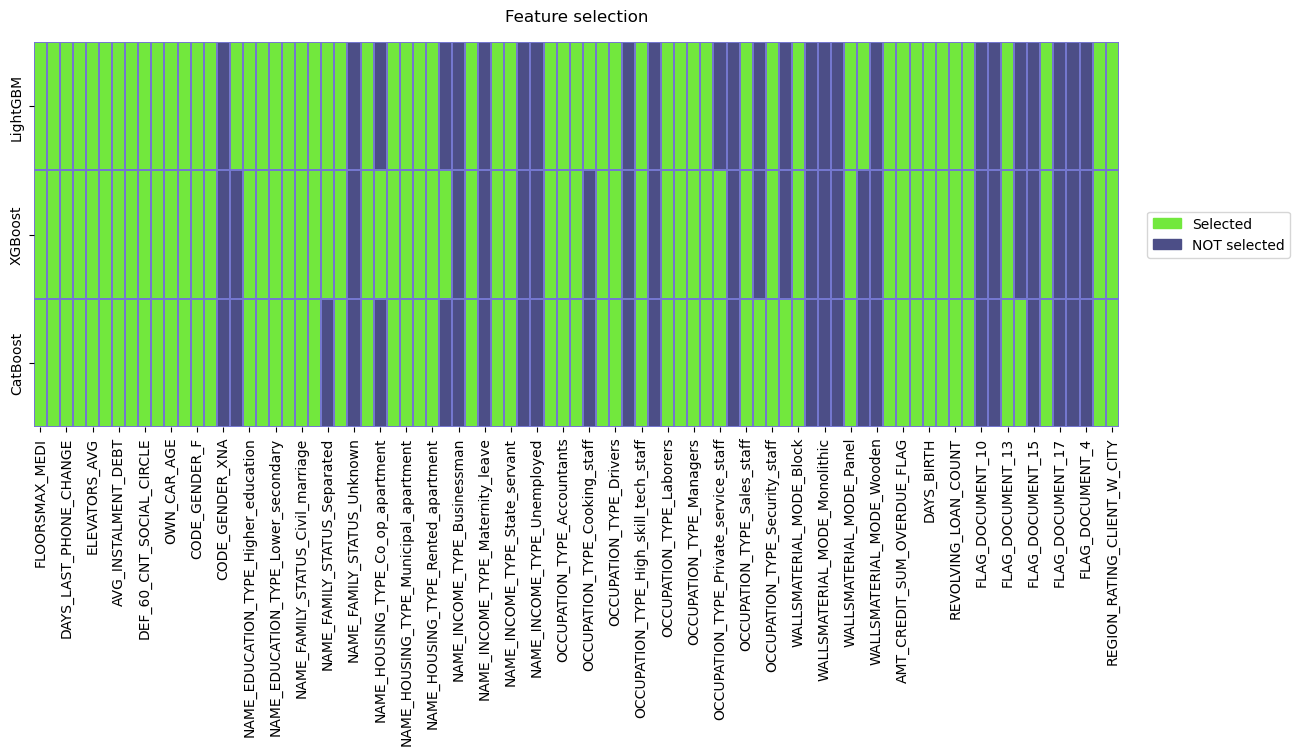

In [62]:
SHAP_selected_cols = {}
SHAP_scores_thresholded = SHAP_scores.copy()
for col in SHAP_scores:
    SHAP_scores_thresholded[col] = np.where(
        abs(SHAP_scores_thresholded[col]) > SHAP_scores[col].quantile(0.30),
        1,
        np.nan,
    )
    print(
        f"{col} selected {SHAP_scores_thresholded[col].value_counts()[1]}/ 82"
    )
    SHAP_selected_cols[col] = SHAP_scores_thresholded[
        SHAP_scores_thresholded[col].notna()
    ][col].index

plot_selection_heatmap(SHAP_scores_thresholded, 5)

#### 8.C.b SHAP selection evaluation

* CatBoost outperforms XGBoost and LightGBM in true positives, with 3 412 detected, just 1 more than before. It remains consistent in capturing positive cases, with the highest recall of 0.687. It showed no AUCPR change, but its stability in true positive capture and recall makes it the most reliable model and outstanding deployment model candidate.
* XGBoost detected 3 401 true positives, slightly lower than CatBoost, and had a small recall decrease (-0.06%).
* LightGBM detected 3 403 true positives, 8 more than before reaching XGBoost model TP count, and although recall increased (+0.24%), it still lagged behind CatBoost by 9 predictions.


In [63]:
SHAP_model_hyper_score = get_SHAP_model_scores(
    SHAP_selected_cols,
    optimized_params,
    catBoost_categories,
    RANDOM_STATE,
    HPT_models,
    train_data_select,
    train_target,
    val_data_select,
    val_target,
    df_hyper_score,
    conf_matix_dict,
)
SHAP_df_hyper_score = pd.DataFrame(SHAP_model_hyper_score)
SHAP_df_hyper_score.set_index("Model", inplace=True)
SHAP_df_hyper_score

LightGBM


,Predicted Negative,Predicted Positive
Actual Negative,39297 (-20),17241
Actual Positive,1562,3403 (8)


XGBoost


,Predicted Negative,Predicted Positive
Actual Negative,39156 (36),17382
Actual Positive,1564,3401 (-2)


CatBoost


,Predicted Negative,Predicted Positive
Actual Negative,38916 (12),17622
Actual Positive,1553,3412 (1)


,Previous F1 Score,F1 Score,Previous recall,Current recall,Improvement of recall,Previous AUCPR,Current AUCPR,Improvement of AUCPR
Model,,,,,,,,
LightGBM,0.265431,0.265766,0.683787,0.685398,0.24 %,0.241924,0.242503,0.24 %
XGBoost,0.263942,0.264176,0.685398,0.684995,-0.06 %,0.241282,0.241735,0.19 %
CatBoost,0.262284,0.262472,0.687009,0.687210,0.03 %,0.238657,0.238661,0.0 %


### 8.D Final model creation and export
#### 8.D.a Creatung final model:

In [115]:
final_columns = SHAP_scores_thresholded[
    SHAP_scores_thresholded["CatBoost"].notna()
].index

optimized_params["CatBoost"].pop("cat_features")
SHAP_cat_cols = list(
    set(catBoost_categories).intersection(set(SHAP_selected_cols["CatBoost"]))
)
optimized_params["CatBoost"]["cat_features"] = SHAP_cat_cols
final_model = CatBoostClassifier(
    **optimized_params["CatBoost"],
    random_state=RANDOM_STATE,
)
final_model.fit(train_data_select[final_columns], train_target);

#### 8.D.b Saving final model to file:

In [72]:
with open("final_columns.pkl", "wb") as f:
    pickle.dump(final_columns, f)

## 9. Conclusions of analysis

This project successfully tackled the challenging task of predicting client payment difficulties using a highly imbalanced dataset. Key steps and insights gained throughout the process are as follows:
##### Data Exploration and Preparation
* A thorough exploratory data analysis revealed critical issues, including significant missingness, class imbalance, and multicollinearity, all of which were effectively addressed through imputation, feature selection, and strategic handling of imbalance.
* Feature engineering and selection emphasized the importance of nuanced financial indicators, such as AVG_INSTALMENT_DEBT and CREDIT_ACTIVE_COUNT, which emerged as strong predictors.
* Careful consideration of multicollinearity and VIF values ensured that only relevant, non-redundant features were retained for modeling.
##### Modeling and Performance
* Among several algorithms tested, CatBoost, LightGBM, and XGBoost emerged as top performers, balancing recall and AUCPR scores effectively to prioritize the identification of positive cases.
* Hyperparameter tuning via Bayesian Optimization further improved model performance, with XGBoost achieving the most significant recall improvement (+8.13%), followed by CatBoost and LightGBM, which maintained strong and stable results.
* SHAP value analysis facilitated refined feature selection, reducing feature sets while preserving predictive strength. CatBoost retained its position as the most consistent model, excelling in recall and true positive detection.
##### Deployment Readiness
* CatBoost was identified as the most reliable deployment candidate due to its consistent recall (0.687), superior ability to capture true positives, and robust performance across metrics.
The model’s interpretability, enhanced through SHAP value analysis, adds confidence to its deployment in decision-making scenarios, ensuring transparency and actionable insights.
##### Business Impact
The deployment of this model has the potential to significantly improve risk management processes by accurately identifying clients at risk of payment difficulties. This allows for targeted interventions, reducing financial losses while supporting clients in mitigating repayment challenges.

## 10. Suggestions for improvement

Here are some points of improvement:
*  Ranking based on composite score rather than weighted sum:
Rather than calculating a weighted sum and then scaling, it would be interesting to try computing the rank of each feature for each metric, then compute a composite rank.
* Occupation type vs TARGET plot has revieled that there are groups of occupations with very similar proportions of people having payment difficulties thus it would be good to define those groups and create a feature of occupation risk level making data less sparse.
* In hyperparameter tunning include the threshold for rank tunning. Initial idea was to select above average rank but this might not neceserily be the case. Also the same could be done for the SHAP value selection.
* 